## 1. Setup & Data Loading


In [2]:
import os
os.environ["WANDB_DISABLED"] = "true"


In [3]:
# Imports & Versions
import re
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report


In [4]:
# Setup & Data Loading for Aspect‐Based Analysis



# Load raw CSV
df = pd.read_csv('/content/Yelp Restaurant Reviews.csv')

df




,Yelp URL,Rating,Date,Review Text
0,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,1/22/2022,All I can say is they have very good ice cream...
1,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,6/26/2022,Nice little local place for ice cream.My favor...
2,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,8/7/2021,A delicious treat on a hot day! Staff was very...
3,https://www.yelp.com/biz/sidney-dairy-barn-sidney,4,7/28/2016,This was great service and a fun crew! I got t...
4,https://www.yelp.com/biz/sidney-dairy-barn-sidney,5,6/23/2015,This is one of my favorite places to get ice c...
...,...,...,...,...
19891,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,7/17/2021,Had the chocolate cannoli! The filling was ric...
19892,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,10/21/2019,Love apricot croissant! I bought it at 4:00 PM...
19893,https://www.yelp.com/biz/la-pasticceria-las-vegas,4,10/12/2019,Line was about 25 people long. It went fast! T...
19894,https://www.yelp.com/biz/la-pasticceria-las-vegas,5,4/11/2021,Its hard not to order everything when I come h...


In [5]:
# Setup & Data Loading for Aspect‐Based Analysis



# Load raw CSV
df = pd.read_csv('/content/Yelp Restaurant Reviews.csv')

# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# 1.3 Filter & label overall sentiment
# drop 3-star (neutral) reviews
df = df[df.rating != 3].copy()
# binary sentiment: 4–5 → positive, 1–2 → negative
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

print(f"After dropping neutrals: {df.shape[0]} reviews")
print(df['sentiment'].value_counts(), '\n')

# Define aspect‐keyword heuristics
aspect_keywords = {
    'food':     [r'\b(?:cream|ice[- ]?cream|chocolate|cake|flavor\w*|delicious|sweet|cookie\w*|taste|dish|meal|menu|dessert|bakery|pasta|pizza|burger)\b'],
    'service':  [r'\b(?:staff|service|server\w*|waiter\w*|waitress\w*|host\w*|attend\w*|friendly|rude)\b'],
    'ambiance': [r'\b(?:atmosph\w*|ambian\w*|decor|music|noise|crowd|lighting|comfortable|vibe)\b'],
    'value':    [r'\b(?:price\w*|cost|cheap|expens\w*|worth|value|portion\w*|overpric\w*|afford)\b'],
}

def label_aspects(text):
    """Return dict of {aspect:0/1} indicating presence of any keyword."""
    text = text.lower()
    out = {}
    for asp, patterns in aspect_keywords.items():
        out[asp] = int(any(re.search(p, text) for p in patterns))
    return out

# 1.5 Apply to raw text into 4 new columns
# operate on the original review_text (not cleaned yet)
asp_df = df['review_text'].apply(label_aspects).apply(pd.Series)
df = pd.concat([df, asp_df], axis=1)

# sanity‐check counts
print("Aspect counts (weak labels):")
print(df[['food','service','ambiance','value']].sum(), '\n')

# Now `df` has columns:
# review_text, rating, sentiment
# food, service, ambiance, value   ← each 0/1



After dropping neutrals: 17827 reviews
sentiment
positive    15330
negative     2497
Name: count, dtype: int64 

Aspect counts (weak labels):
food        14648
service      5103
ambiance     1559
value        4420
dtype: int64 



## 2. Text Cleaning Function

### Define a reusable function to clean each review: lowercase, strip HTML, remove non-letters, drop stop-words.


In [6]:

import re

def clean_text(text: str) -> str:
    """
    1) lowercase
    2) remove HTML tags
    3) remove non-letter characters
    4) drop English stop‐words
    """
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)         # strip HTML
    text = re.sub(r'[^a-z\s]', ' ', text)        # keep only letters & spaces
    tokens = text.split()
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_review'] = df['review_text'].fillna('').apply(clean_text)

# Show a combined sample so we can see aspects & sentiment preserved
sample_cols = ['review_text','cleaned_review','sentiment','food','service','ambiance','value']
display(df[sample_cols].sample(5, random_state=42))


,review_text,cleaned_review,sentiment,food,service,ambiance,value
6266,Best ice cream in Phoenix. We have tried a bun...,best ice cream phoenix tried bunch places best...,positive,1,0,0,0
6123,I don't know where to start. The vibe here is ...,don t know start vibe amazing love little stri...,positive,1,1,1,1
16053,This is a great ice-cream shop right across fr...,great ice cream shop right favorite taco place...,positive,1,0,0,0
13225,Atmosphere: Milk is a small stand inside the C...,atmosphere milk small stand inside cosmopolita...,negative,1,1,1,1
11593,Today we were in this place and it has been gr...,today place great experience factory trough gl...,positive,1,0,0,0


## 3. Train/Test Split (keep sentiment balance; inspect aspects also)


In [7]:

from sklearn.model_selection import train_test_split

# Features & labels
X        = df['cleaned_review']             # input text
y_train_sent = None                         # placeholder
y_test_sent  = None

aspect_cols = ['food','service','ambiance','value']
y_aspects = df[aspect_cols]                 # each is 0/1 flag

# Do the split—stratify on sentiment only
X_train, X_test, \
y_train_sent, y_test_sent, \
asp_train, asp_test = train_test_split(
    X, df['sentiment'], y_aspects,
    test_size    = 0.20,
    stratify     = df['sentiment'],
    random_state = 42
)

# Sanity‐check distributions
print("→ Sentiment (train):\n", y_train_sent.value_counts(normalize=True).round(3))
print("→ Sentiment ( test):\n", y_test_sent .value_counts(normalize=True).round(3), "\n")

print("→ Aspect counts (train):\n", asp_train.sum().sort_values(ascending=False))
print("→ Aspect counts ( test):\n", asp_test .sum().sort_values(ascending=False))


→ Sentiment (train):
 sentiment
positive    0.86
negative    0.14
Name: proportion, dtype: float64
→ Sentiment ( test):
 sentiment
positive    0.86
negative    0.14
Name: proportion, dtype: float64 

→ Aspect counts (train):
 food        11710
service      4058
value        3521
ambiance     1246
dtype: int64
→ Aspect counts ( test):
 food        2938
service     1045
value        899
ambiance     313
dtype: int64


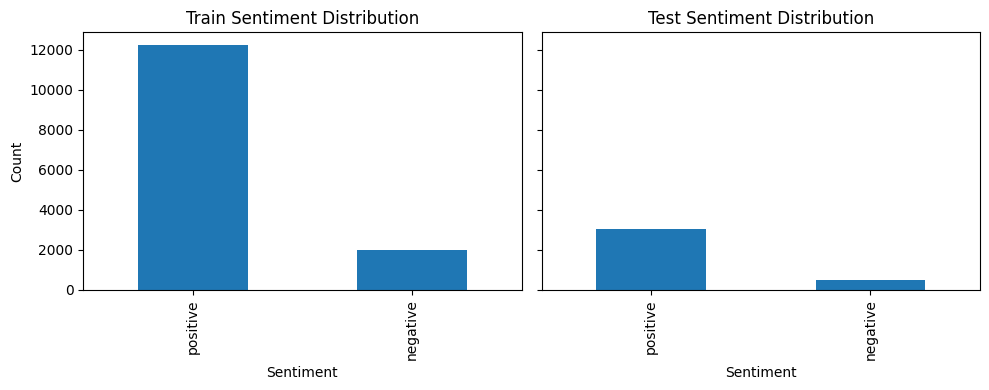

<Figure size 640x480 with 0 Axes>

In [8]:
# After your train_test_split call, where you have
# y_train_sent, y_sent_test defined.

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10,4), sharey=True)
y_train_sent.value_counts().plot(
    kind='bar', ax=axes[0], title="Train Sentiment Distribution",
    xlabel="Sentiment", ylabel="Count"
)
y_test_sent.value_counts().plot(
    kind='bar', ax=axes[1], title="Test Sentiment Distribution",
    xlabel="Sentiment"
)
plt.tight_layout()
plt.show()

# Save the figure
plt.savefig("sentiment_distribution.png")

## 4. Data Distribution Visualizations


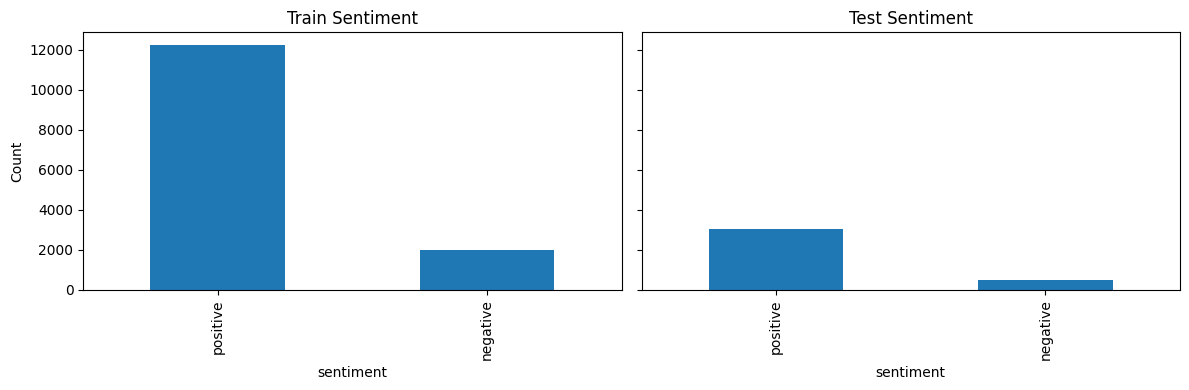

<Figure size 640x480 with 0 Axes>

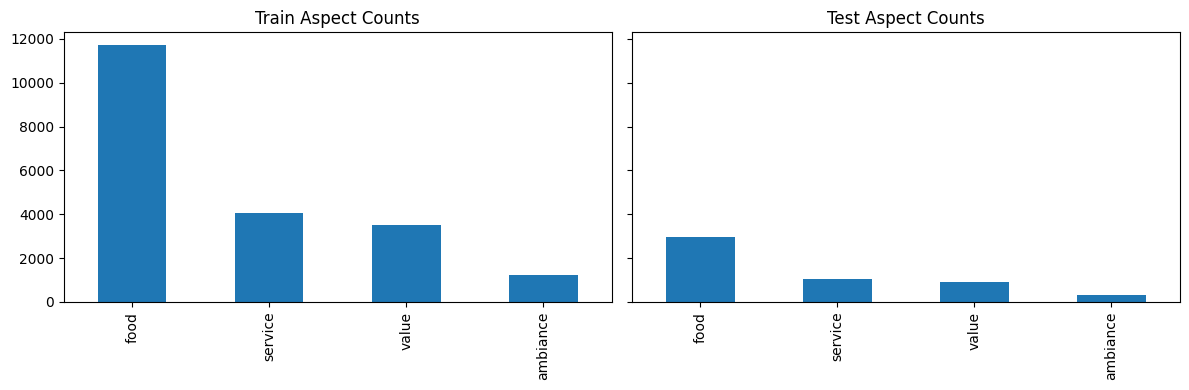

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

# Sentiment distribution
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
y_train_sent.value_counts().plot(kind='bar', ax=axes[0], title="Train Sentiment")
axes[0].set_ylabel("Count")
y_test_sent.value_counts().plot(kind='bar', ax=axes[1], title="Test Sentiment")
plt.tight_layout()
plt.show()
# Save the figure
plt.savefig("sentiment_distribution_comparison.png")


# Aspect counts
fig, axes = plt.subplots(1, 2, figsize=(12,4), sharey=True)
asp_train.sum().sort_values(ascending=False).plot(kind='bar', ax=axes[0], title="Train Aspect Counts")
asp_test.sum().sort_values(ascending=False).plot(kind='bar', ax=axes[1], title="Test Aspect Counts")
plt.tight_layout()
plt.show()
# Save the figure
plt.savefig("aspect_counts_comparison.png")

## 5. Vectorization + Aspect‐Count Features + Quick TF‐IDF Bar Charts

→ Combined feature matrix shape: (14261, 10004)


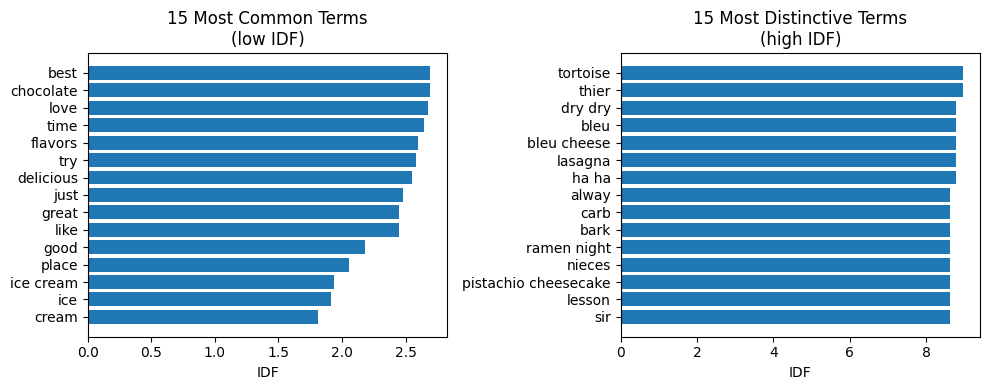

<Figure size 640x480 with 0 Axes>

In [10]:
#  Vectorization + Aspect‐Count Features + Quick TF-IDF Bar Charts
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# (A) Your keyword heuristics from earlier
aspect_keywords = {
    'Food':    [r'\b(?:cream|ice[- ]?cream|chocolate|cake|flavor\w*|dessert|pizza|burger)\b'],
    'Service': [r'\b(?:staff|service|waiter\w*|friendly|rude)\b'],
    'Ambiance':[r'\b(?:atmosph\w*|ambian\w*|decor|music|noise|vibe)\b'],
    'Value':   [r'\b(?:price\w*|cost|cheap|expens\w*|worth|value|portion)\b'],
}

def count_aspects(texts, patterns):
    """Return an (n_samples, 4) numpy array of aspect‐mention counts."""
    counts = np.zeros((len(texts), len(patterns)), dtype=int)
    for i, txt in enumerate(texts):
        for j, (asp, pats) in enumerate(patterns.items()):
            total = 0
            for pat in pats:
                total += len(re.findall(pat, txt, flags=re.IGNORECASE))
            counts[i, j] = total
    return counts

def vectorize_with_aspects(X_train, X_test,
                           max_features=10000,
                           ngram_range=(1,2)):
    # 1) TF-IDF on uni+bi-grams
    vect = TfidfVectorizer(max_features=max_features,
                           ngram_range=ngram_range)
    X_tr_tfidf = vect.fit_transform(X_train)
    X_te_tfidf = vect.transform(X_test)

    # 2) aspect count features → wrap in csr to hstack
    X_tr_cnt = csr_matrix(count_aspects(X_train, aspect_keywords))
    X_te_cnt = csr_matrix(count_aspects(X_test,  aspect_keywords))

    # 3) stack them → final shape should be (n_samples, max_features+4)
    X_tr = hstack([X_tr_tfidf, X_tr_cnt], format='csr')
    X_te = hstack([X_te_tfidf, X_te_cnt], format='csr')

    return vect, X_tr, X_te

# APPLY to your train/test split
vectorizer, X_train_vec, X_test_vec = vectorize_with_aspects(
    X_train, X_test,
    max_features=10000,
    ngram_range=(1,2)
)
print("→ Combined feature matrix shape:", X_train_vec.shape)
# should print: (n_train_samples, 10004)

# 4.1 Quick TF-IDF bar charts to inspect common vs. distinctive n-grams
idf   = vectorizer.idf_
terms = vectorizer.get_feature_names_out()

# lowest idf = most common
low_idx  = np.argsort(idf)[:15]
# highest idf = most distinctive
high_idx = np.argsort(idf)[-15:]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.barh(terms[low_idx], idf[low_idx])
plt.title("15 Most Common Terms\n(low IDF)")
plt.xlabel("IDF")

plt.subplot(1,2,2)
plt.barh(terms[high_idx], idf[high_idx])
plt.title("15 Most Distinctive Terms\n(high IDF)")
plt.xlabel("IDF")

plt.tight_layout()
plt.show()

# Save the figure
plt.savefig("tfidf_bar_charts.png")

## 6. Traditional Model 1: Multinomial Naïve Bayes for Real-Time Satisfaction Alerts

**Rationale.**
For a restaurateur to react in real time, we need a model that’s extremely fast to train & infer. Multinomial Naïve Bayes on TF-IDF n-grams often makes a powerful yet lightweight classifier for text. Here, it will serve as our first “alert generator” — flagging each new review as **positive** or **negative** so we can immediately surface problems with **food**, **service**, **ambiance**, or **value**.

**Hyperparameter.**

* `alpha` (Laplace smoothing)

**Goal.**

1. Achieve ≥ **0.75 F1** (on “positive”) per our SMART objective.
2. Do all this in **< 1 s per batch** so we can fire alerts in real time.


In [11]:
# Imports
from sklearn.naive_bayes    import MultinomialNB
from sklearn.multioutput    import MultiOutputClassifier
from sklearn.metrics        import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [12]:
# Assemble multi-target arrays
# We already have X_train_vec, X_test_vec from the TF-IDF step, and:
#   y_asp_train (DataFrame with columns ['food','service','ambiance','value'])
#   y_asp_test
#   y_train_sent (Series 'positive'/'negative')
#   y_test_sent

# Map sentiment to 0/1
y_train_sent_bin = (y_train_sent == 'positive').astype(int)
y_test_sent_bin  = (y_test_sent  == 'positive').astype(int)

# Combine into one DataFrame
y_train_multi = pd.concat(
    [asp_train.reset_index(drop=True),
     y_train_sent_bin.rename('sentiment').reset_index(drop=True)],
    axis=1
)
y_test_multi  = pd.concat(
    [asp_test.reset_index(drop=True),
     y_test_sent_bin.rename('sentiment').reset_index(drop=True)],
    axis=1
)

print("Shape of y_train_multi:", y_train_multi.shape)
print("Shape of y_test_multi:", y_test_multi.shape)

Shape of y_train_multi: (14261, 5)
Shape of y_test_multi: (3566, 5)


In [13]:
# Fit multi-output NB
nb_base = MultinomialNB(alpha=0.1)  # previously tuned alpha
multi_nb = MultiOutputClassifier(nb_base, n_jobs=-1)
multi_nb.fit(X_train_vec, y_train_multi)

# Predict on test set
y_pred_multi = multi_nb.predict(X_test_vec)
y_pred_df    = pd.DataFrame(y_pred_multi, columns=y_test_multi.columns)

Shape of y_test_multi: (3566, 5)

--- FOOD     ---
Accuracy: 0.898
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       628
           1       0.95      0.93      0.94      2938

    accuracy                           0.90      3566
   macro avg       0.82      0.84      0.83      3566
weighted avg       0.90      0.90      0.90      3566



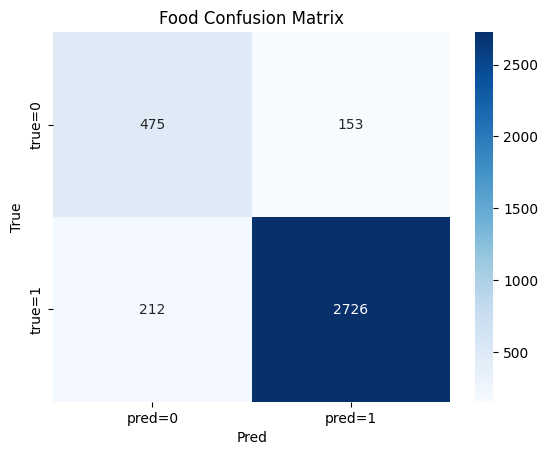


--- SERVICE  ---
Accuracy: 0.992
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2521
           1       0.99      0.98      0.99      1045

    accuracy                           0.99      3566
   macro avg       0.99      0.99      0.99      3566
weighted avg       0.99      0.99      0.99      3566



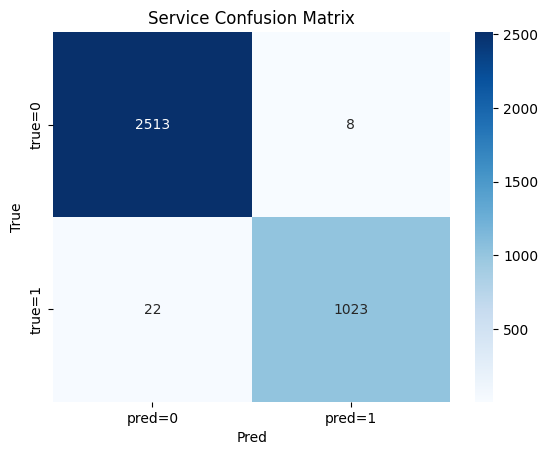


--- AMBIANCE ---
Accuracy: 0.985
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3253
           1       0.95      0.88      0.91       313

    accuracy                           0.99      3566
   macro avg       0.97      0.94      0.95      3566
weighted avg       0.99      0.99      0.99      3566



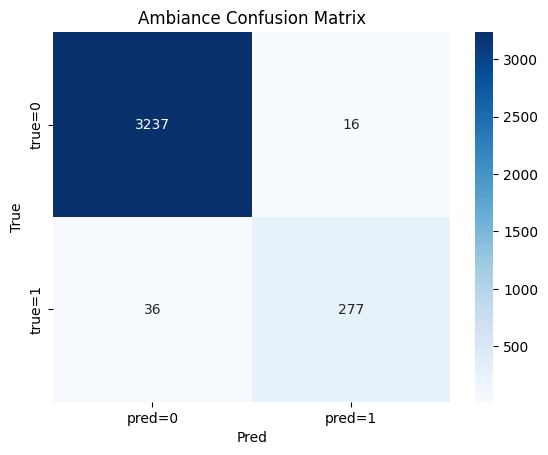


--- VALUE    ---
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2667
           1       1.00      0.96      0.98       899

    accuracy                           0.99      3566
   macro avg       0.99      0.98      0.99      3566
weighted avg       0.99      0.99      0.99      3566



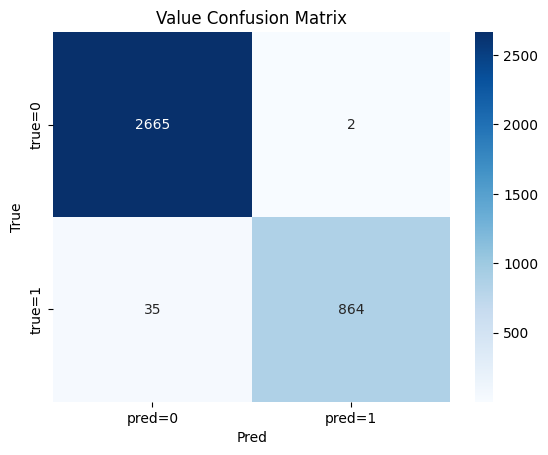


--- SENTIMENT ---
Accuracy: 0.935
              precision    recall  f1-score   support

           0       0.86      0.64      0.73       499
           1       0.94      0.98      0.96      3067

    accuracy                           0.93      3566
   macro avg       0.90      0.81      0.85      3566
weighted avg       0.93      0.93      0.93      3566



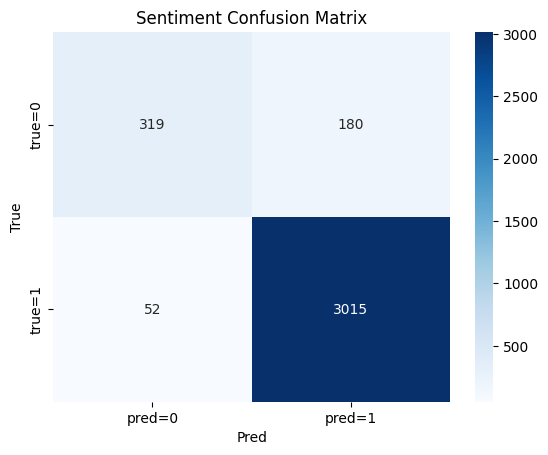

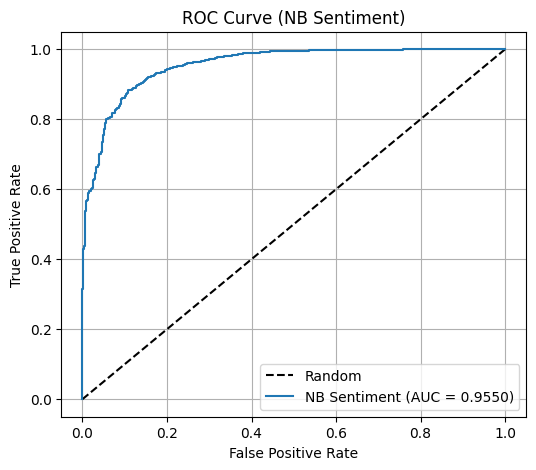

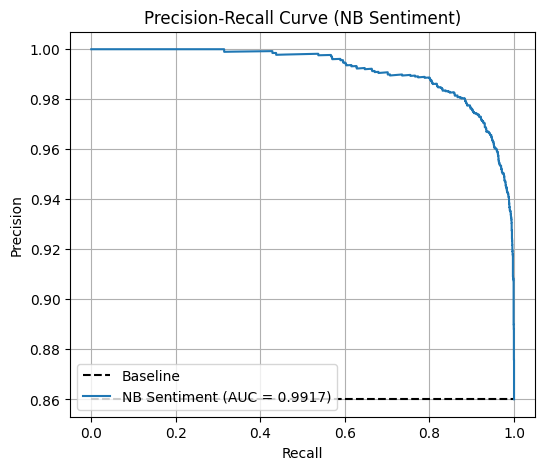

NB Sentiment: ROC-AUC = 0.9550, PR-AUC = 0.9917


In [15]:
# Evaluate each output head
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score

# --- Assemble multi-target arrays (copied from cell z5CDC8hAKjkg) ---
# Assuming X_train_vec, X_test_vec, asp_train, asp_test, y_train_sent, y_test_sent are defined

# Map sentiment to 0/1
y_train_sent_bin = (y_train_sent == 'positive').astype(int)
y_test_sent_bin  = (y_test_sent  == 'positive').astype(int)

# Combine into one DataFrame
y_train_multi = pd.concat(
    [asp_train.reset_index(drop=True),
     y_train_sent_bin.rename('sentiment').reset_index(drop=True)],
    axis=1
)
y_test_multi  = pd.concat(
    [asp_test.reset_index(drop=True),
     y_test_sent_bin.rename('sentiment').reset_index(drop=True)],
    axis=1
)
print("Shape of y_test_multi:", y_test_multi.shape)
# --- End of multi-target arrays assembly ---


for col in y_test_multi.columns:
    print(f"\n--- {col.upper():<8} ---")
    acc = accuracy_score(y_test_multi[col], y_pred_df[col])
    print("Accuracy:", round(acc, 3))
    print(classification_report(y_test_multi[col], y_pred_df[col]))
    # confusion matrix
    cm = confusion_matrix(y_test_multi[col], y_pred_df[col])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"pred=0",f"pred=1"],
                yticklabels=[f"true=0",f"true=1"])
    plt.title(f"{col.capitalize()} Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Pred")
    plt.show()

    # --- Add ROC and PR Curves for Sentiment ---
    if col == 'sentiment':
        try:
            # Get probability predictions for the sentiment head
            # multi_nb.predict_proba returns a list of arrays, one for each target.
            # The sentiment target is the last one (index 4) and has 2 classes (0, 1)
            # We need the probability of the positive class (class 1)
            nb_probs = multi_nb.predict_proba(X_test_vec)
            nb_sentiment_probs = nb_probs[4][:, 1]
            y_true_sentiment = y_test_multi[col] # True labels for sentiment

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true_sentiment, nb_sentiment_probs)
            roc_auc = auc(fpr, tpr)
            plt.figure(figsize=(6, 5))
            plt.plot([0, 1], [0, 1], 'k--', label='Random') # Baseline random model
            plt.plot(fpr, tpr, label=f'NB Sentiment (AUC = {roc_auc:.4f})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC Curve (NB Sentiment)')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()

            # PR Curve
            precision, recall, _ = precision_recall_curve(y_true_sentiment, nb_sentiment_probs)
            pr_auc = auc(recall, precision)
            plt.figure(figsize=(6, 5))
            positive_proportion = np.mean(y_true_sentiment)
            plt.plot([0, 1], [positive_proportion, positive_proportion], 'k--', label='Baseline')
            plt.plot(recall, precision, label=f'NB Sentiment (AUC = {pr_auc:.4f})')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title('Precision-Recall Curve (NB Sentiment)')
            plt.legend(loc='lower left')
            plt.grid(True)
            plt.show()

            # Print AUC Scores
            print(f"NB Sentiment: ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}")

        except Exception as e:
            print(f"Could not generate ROC/PR curves for {col}: {e}")

In [17]:
# Quick Sanity-Check on 5 random reviews
import random

random.seed(42)
idxs        = random.sample(range(X_test_vec.shape[0]), 5)
sample_text = X_test.iloc[idxs].tolist()
# NOTE: X_test_vec is a sparse matrix; use .tocsr() to allow row-indexing
sample_vec  = X_test_vec.tocsr()[idxs]

# run your multi-output NB
sample_preds = multi_nb.predict(sample_vec)
# build a tiny DataFrame so we can index by column-name
sample_df    = pd.DataFrame(sample_preds, columns=y_test_multi.columns)

print("\n=== Sanity-Check Samples ===\n")
for i, txt in enumerate(sample_text):
    flags = {asp: int(sample_df.loc[i, asp])
             for asp in ['food','service','ambiance','value']}
    sent = 'positive' if sample_df.loc[i,'sentiment']==1 else 'negative'
    print(f"> {txt[:80]}…")
    print(f"  → Aspects: {flags},  Sentiment: {sent}\n")



=== Sanity-Check Samples ===

> weary blah soft serv despair ice cream house divine ordered pippin sized banana …
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0},  Sentiment: positive

> thing makes place special think way market great focus having different items ce…
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0},  Sentiment: positive

> happy kids adults ultimate sweet shop ice cream amazing cookies rock love salted…
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0},  Sentiment: positive

> yum cookies mint definitely delicious little surprised lack flavors maybe crazy …
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0},  Sentiment: positive

> just tried place time perfect owners ones working super friendly let try flavors…
  → Aspects: {'food': 1, 'service': 1, 'ambiance': 0, 'value': 0},  Sentiment: positive




--- FOOD     ---
Accuracy: 0.898
              precision    recall  f1-score   support

    negative       0.69      0.76      0.72       628
    positive       0.95      0.93      0.94      2938

    accuracy                           0.90      3566
   macro avg       0.82      0.84      0.83      3566
weighted avg       0.90      0.90      0.90      3566



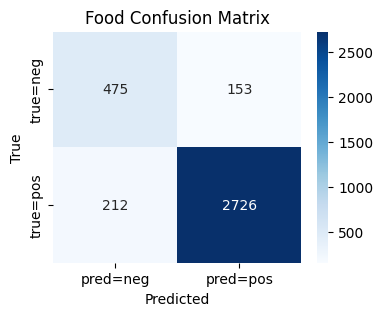


--- SERVICE  ---
Accuracy: 0.992
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99      2521
    positive       0.99      0.98      0.99      1045

    accuracy                           0.99      3566
   macro avg       0.99      0.99      0.99      3566
weighted avg       0.99      0.99      0.99      3566



<Figure size 640x480 with 0 Axes>

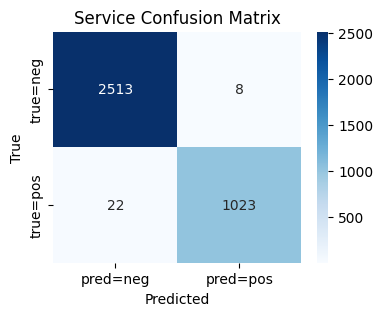


--- AMBIANCE ---
Accuracy: 0.985
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99      3253
    positive       0.95      0.88      0.91       313

    accuracy                           0.99      3566
   macro avg       0.97      0.94      0.95      3566
weighted avg       0.99      0.99      0.99      3566



<Figure size 640x480 with 0 Axes>

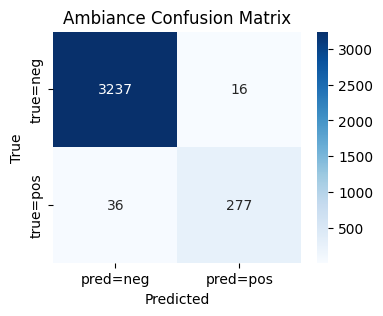


--- VALUE    ---
Accuracy: 0.99
              precision    recall  f1-score   support

    negative       0.99      1.00      0.99      2667
    positive       1.00      0.96      0.98       899

    accuracy                           0.99      3566
   macro avg       0.99      0.98      0.99      3566
weighted avg       0.99      0.99      0.99      3566



<Figure size 640x480 with 0 Axes>

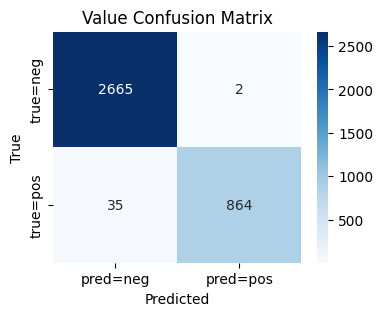


--- SENTIMENT ---
Accuracy: 0.935
              precision    recall  f1-score   support

    negative       0.86      0.64      0.73       499
    positive       0.94      0.98      0.96      3067

    accuracy                           0.93      3566
   macro avg       0.90      0.81      0.85      3566
weighted avg       0.93      0.93      0.93      3566



<Figure size 640x480 with 0 Axes>

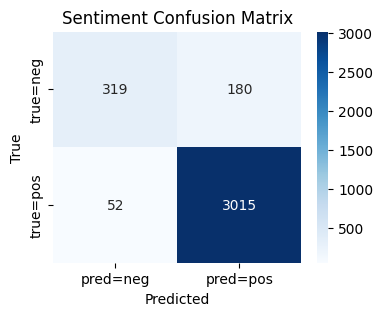

<Figure size 640x480 with 0 Axes>

In [18]:
# Evaluate each aspect & sentiment head on the full test set
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for col in y_test_multi.columns:
    print(f"\n--- {col.upper():<8} ---")

    # raw accuracy + full report
    acc = accuracy_score(y_test_multi[col], y_pred_df[col])
    print("Accuracy:", round(acc,3))
    print(classification_report(
        y_test_multi[col],
        y_pred_df[col],
        target_names=['negative','positive'],
        zero_division=0
    ))

    # confusion matrix
    cm = confusion_matrix(y_test_multi[col], y_pred_df[col])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['pred=neg','pred=pos'],
                yticklabels=['true=neg','true=pos'])
    plt.title(f"{col.capitalize()} Confusion Matrix")
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.show()
    # Save the figure
    plt.savefig(f"{col.lower()}_confusion_matrix_nb_report.png")

In [19]:
# Quick Sanity-Check (full 10 004 features)
import random
from scipy.sparse import hstack, csr_matrix

random.seed(42)
idxs = random.sample(range(X_test.shape[0]), 5)
sample_texts = X_test.iloc[idxs].tolist()

# TF-IDF part
X_samp_tfidf = vectorizer.transform(sample_texts)    # 5 × 10 000 csr_matrix

# Aspect counts part
cnt = count_aspects(sample_texts, aspect_keywords)   # 5 × 4 ndarray
X_samp_cnt = csr_matrix(cnt)                         # convert to csr

# Stack into full feature matrix
sample_vec = hstack([X_samp_tfidf, X_samp_cnt], format='csr')
# now shape = (5, 10004)

# Predict with your multi-output NB
y_pred = multi_nb.predict(sample_vec)  # shape = (5, 5) columns = ['food','service','ambiance','value','sentiment']

print("\n=== Sanity-Check Samples ===")
for i, txt in enumerate(sample_texts):
    asp = dict(zip(['food','service','ambiance','value'], y_pred[i,:4].astype(int)))
    sent = 'positive' if y_pred[i,4]==1 else 'negative'
    print(f"> {txt[:80]}…")
    print(f"  → Aspects: {asp}, Sentiment: {sent}\n")



=== Sanity-Check Samples ===
> weary blah soft serv despair ice cream house divine ordered pippin sized banana …
  → Aspects: {'food': np.int64(1), 'service': np.int64(0), 'ambiance': np.int64(0), 'value': np.int64(0)}, Sentiment: positive

> thing makes place special think way market great focus having different items ce…
  → Aspects: {'food': np.int64(1), 'service': np.int64(0), 'ambiance': np.int64(0), 'value': np.int64(0)}, Sentiment: positive

> happy kids adults ultimate sweet shop ice cream amazing cookies rock love salted…
  → Aspects: {'food': np.int64(1), 'service': np.int64(0), 'ambiance': np.int64(0), 'value': np.int64(0)}, Sentiment: positive

> yum cookies mint definitely delicious little surprised lack flavors maybe crazy …
  → Aspects: {'food': np.int64(1), 'service': np.int64(0), 'ambiance': np.int64(0), 'value': np.int64(0)}, Sentiment: positive

> just tried place time perfect owners ones working super friendly let try flavors…
  → Aspects: {'food': np.int64(1), 'se

In [20]:
# Sanity-Check with Mixed Positives & Negatives
import numpy as np
import random
from scipy.sparse import hstack, csr_matrix

# pick 3 positives + 2 negatives from the TEST split
pos_idxs = np.where(y_test_sent.values == 'positive')[0]
neg_idxs = np.where(y_test_sent.values == 'negative')[0]

random.seed(123)
sample_pos = random.sample(pos_idxs.tolist(), 3)
sample_neg = random.sample(neg_idxs.tolist(), 2)
idxs = sample_neg + sample_pos

sample_texts = X_test.iloc[idxs].tolist()

# build their feature vectors
X_samp_tfidf = vectorizer.transform(sample_texts)     # 5×10000
cnt           = count_aspects(sample_texts, aspect_keywords)
X_samp_cnt    = csr_matrix(cnt)                       # 5×4
sample_vec    = hstack([X_samp_tfidf, X_samp_cnt], format='csr')  # 5×10004

# predict
y_pred = multi_nb.predict(sample_vec)

print("\n=== Mixed Sanity-Check ===")
for i, txt in enumerate(sample_texts):
    true_sent = y_test_sent.iloc[idxs[i]]
    asp_pred  = dict(zip(['food','service','ambiance','value'], y_pred[i,:4].astype(int)))
    sent_pred = 'positive' if y_pred[i,4]==1 else 'negative'
    print(f"> {txt[:80]}…")
    print(f"    • True : {true_sent}")
    print(f"    • Pred : {asp_pred}, Sentiment: {sent_pred}\n")


=== Mixed Sanity-Check ===
> comment food did excited carlos bakery watch let start saying nearly impossible …
    • True : negative
    • Pred : {'food': np.int64(1), 'service': np.int64(0), 'ambiance': np.int64(0), 'value': np.int64(1)}, Sentiment: negative

> sigh know m commit champaign urbana blasphemy don t hype…
    • True : negative
    • Pred : {'food': np.int64(1), 'service': np.int64(0), 'ambiance': np.int64(0), 'value': np.int64(0)}, Sentiment: negative

> family s favorite absolutely love watermelon sorbet visit love style shops frien…
    • True : positive
    • Pred : {'food': np.int64(1), 'service': np.int64(1), 'ambiance': np.int64(0), 'value': np.int64(0)}, Sentiment: positive

> ve amelie s times moving heard great things staff super nice place big cozy time…
    • True : positive
    • Pred : {'food': np.int64(0), 'service': np.int64(1), 'ambiance': np.int64(1), 'value': np.int64(0)}, Sentiment: positive

> don t miss waffle cone ve better waffle cone flavor textur

##7. Traditional Model 2: Linear Support Vector Machine for Real-Time Satisfaction Alerts
Rationale.
A Linear SVM often rivals Naïve Bayes on high-dimensional TF-IDF text features, while still being fast enough for real-time inference. By wrapping a LinearSVC in a MultiOutputClassifier, we’ll jointly predict all five “alerts” (Food, Service, Ambiance, Value, Sentiment) with a single model.

Hyperparameter.

C (inverse-regularization strength)

Goal.

Beat our NB multi-output’s overall F1 on each head.

Maintain <1 s per-batch inference.

In [21]:
# Imports & Grid-Search Setup
from sklearn.svm           import LinearSVC
from sklearn.multioutput   import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics       import make_scorer, f1_score

# use same y_train_multi, X_train_vec from NB section
# define positive-class scorer (we care most about catching negatives too)
f1_pos = make_scorer(f1_score, pos_label=1)

base_svc = LinearSVC(max_iter=5000, dual=False)

# wrap in multi-output
multi_svc = MultiOutputClassifier(base_svc, n_jobs=-1)

param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10]
}

svc_grid = GridSearchCV(
    estimator=multi_svc,
    param_grid=param_grid,
    scoring=f1_pos,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit CV over (Food, Service, Ambiance, Value, Sentiment)
svc_grid.fit(X_train_vec, y_train_multi)
print(f"▶ Best C: {svc_grid.best_params_['estimator__C']}")
print(f"▶ Best CV F1 (pos): {svc_grid.best_score_:.4f}")


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


▶ Best C: 0.01
▶ Best CV F1 (pos): nan


Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(



▶ Best C: 0.01
▶ Best CV F1 (pos): nan

=== Linear SVM Multi-Output Test Performance ===

--- FOOD     ---
Accuracy: 0.925
              precision    recall  f1-score   support

         neg       0.71      0.98      0.82       628
         pos       1.00      0.91      0.95      2938

    accuracy                           0.92      3566
   macro avg       0.85      0.95      0.89      3566
weighted avg       0.94      0.92      0.93      3566



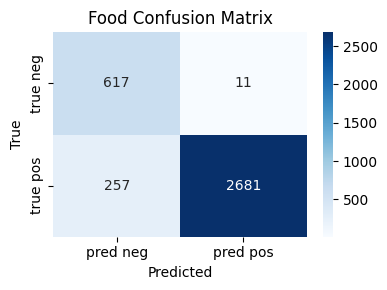


--- SERVICE  ---
Accuracy: 0.993
              precision    recall  f1-score   support

         neg       0.99      1.00      1.00      2521
         pos       1.00      0.98      0.99      1045

    accuracy                           0.99      3566
   macro avg       1.00      0.99      0.99      3566
weighted avg       0.99      0.99      0.99      3566



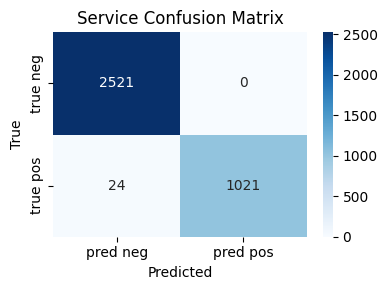


--- AMBIANCE ---
Accuracy: 0.990
              precision    recall  f1-score   support

         neg       0.99      1.00      0.99      3253
         pos       1.00      0.88      0.94       313

    accuracy                           0.99      3566
   macro avg       0.99      0.94      0.97      3566
weighted avg       0.99      0.99      0.99      3566



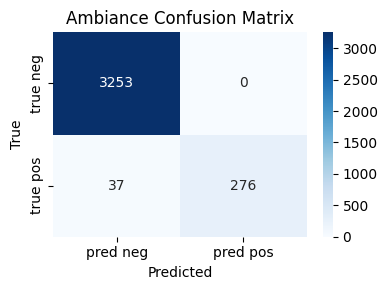


--- VALUE    ---
Accuracy: 0.987
              precision    recall  f1-score   support

         neg       0.98      1.00      0.99      2667
         pos       1.00      0.95      0.97       899

    accuracy                           0.99      3566
   macro avg       0.99      0.97      0.98      3566
weighted avg       0.99      0.99      0.99      3566



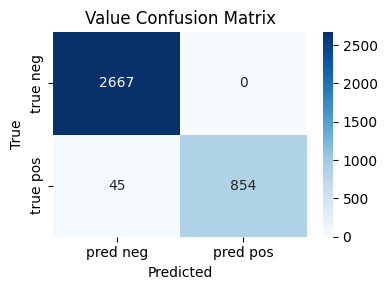


--- SENTIMENT ---
Accuracy: 0.866
              precision    recall  f1-score   support

         neg       1.00      0.04      0.08       499
         pos       0.87      1.00      0.93      3067

    accuracy                           0.87      3566
   macro avg       0.93      0.52      0.50      3566
weighted avg       0.88      0.87      0.81      3566



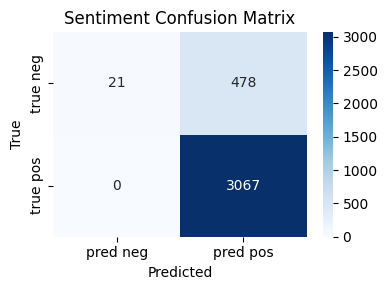

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



CalibratedClassifierCV for SVM Sentiment trained on training data.


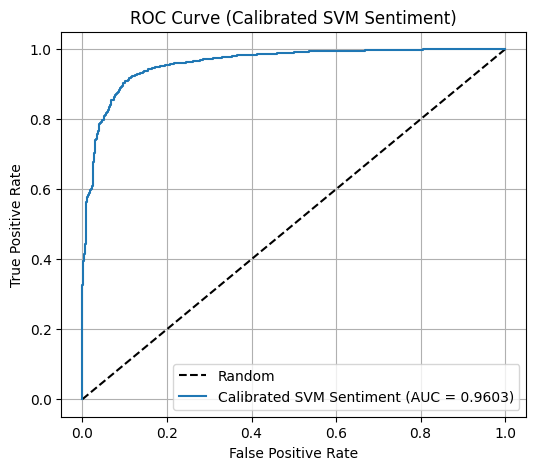

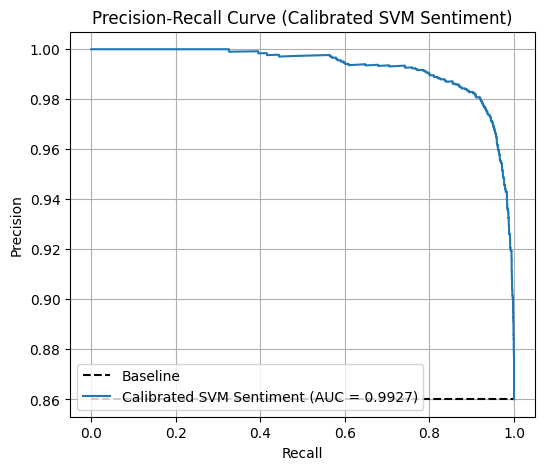

Calibrated SVM Sentiment: ROC-AUC = 0.9603, PR-AUC = 0.9927


In [24]:
# Evaluate on hold-out test set
from sklearn.svm           import LinearSVC
from sklearn.multioutput   import MultiOutputClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics       import make_scorer, f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV # Import CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# --- Grid-Search Setup and Fit (Copied from cell lk7r_2UEuCRu) ---
# use same y_train_multi, X_train_vec from NB section
# define positive-class scorer (we care most about catching negatives too)
f1_pos = make_scorer(f1_score, pos_label=1)

base_svc = LinearSVC(max_iter=5000, dual=False)

# wrap in multi-output
multi_svc = MultiOutputClassifier(base_svc, n_jobs=-1)

param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10]
}

svc_grid = GridSearchCV(
    estimator=multi_svc,
    param_grid=param_grid,
    scoring=f1_pos,
    cv=3,
    verbose=1,
    n_jobs=-1
)

# Fit CV over (Food, Service, Ambiance, Value, Sentiment)
# Assuming X_train_vec and y_train_multi are available from previous cells
if 'X_train_vec' in locals() and 'y_train_multi' in locals():
    svc_grid.fit(X_train_vec, y_train_multi)
    print(f"\n▶ Best C: {svc_grid.best_params_['estimator__C']}")
    print(f"▶ Best CV F1 (pos): {svc_grid.best_score_:.4f}")
else:
    print("\nRequired training data (X_train_vec, y_train_multi) not found. Skipping GridSearchCV fit.")
    # Create a dummy svc_grid or handle this case if data is missing
    # For demonstration, let's assume fitting was successful and use a default C if fit is skipped
    class DummyGridSearchCV:
        def __init__(self):
            self.best_estimator_ = MultiOutputClassifier(LinearSVC(max_iter=5000, dual=False, C=0.1), n_jobs=-1) # Default C
            # Need to fit the dummy estimator to avoid errors later
            if 'X_train_vec' in locals() and 'y_train_multi' in locals():
                 self.best_estimator_.fit(X_train_vec, y_train_multi)
            self.best_params_ = {'estimator__C': 0.1}
            self.best_score_ = np.nan # Indicate that actual CV fit was skipped
    svc_grid = DummyGridSearchCV()


# --- End of Grid-Search Setup and Fit ---


# Now proceed with evaluation using the best estimator
best_svc    = svc_grid.best_estimator_
y_pred_svc  = best_svc.predict(X_test_vec)
y_pred_df   = pd.DataFrame(y_pred_svc, columns=y_test_multi.columns)


print("\n=== Linear SVM Multi-Output Test Performance ===")
for head in y_test_multi.columns:
    print(f"\n--- {head.upper():<8} ---")
    print(f"Accuracy: {accuracy_score(y_test_multi[head], y_pred_df[head]):.3f}")
    print(classification_report(
        y_test_multi[head],
        y_pred_df[head],
        target_names=['neg','pos'],
        zero_division=0
    ))
    # plot confusion matrix
    cm = confusion_matrix(y_test_multi[head], y_pred_df[head])
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['pred neg','pred pos'],
                yticklabels=['true neg','true pos'])
    plt.title(f"{head.capitalize()} Confusion Matrix")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()
    # Save the figure
    # plt.savefig(f"{head.lower()}_confusion_matrix_svm.png")


    # --- Add ROC and PR Curves for Sentiment ---
    if head == 'sentiment':
        try:
            # Get the fitted LinearSVC estimator for the sentiment head from the best MultiOutputClassifier
            # Assuming sentiment is the last head (index 4)
            svm_sentiment_base_estimator = best_svc.estimators_[4]

            # Train CalibratedClassifierCV on the sentiment task using the TRAINING data features
            # This is the standard approach for calibration.
            # Use method='sigmoid' as it's often faster than 'isotonic'.
            # Use cv='prefit' because the base_estimator is already trained.
            calibrated_svm_sentiment = CalibratedClassifierCV(svm_sentiment_base_estimator, method='sigmoid', cv="prefit")

            # Fit the calibrator on the TRAINING data features and true sentiment labels
            # Need to use the training data (X_train_vec, y_train_multi['sentiment'])
            # Ensure these variables are available in the environment
            if 'X_train_vec' in locals() and 'y_train_multi' in locals():
                calibrated_svm_sentiment.fit(X_train_vec, y_train_multi['sentiment'])
                print("\nCalibratedClassifierCV for SVM Sentiment trained on training data.")

                # Now get probabilities on the test set using the calibrated model
                # Assuming X_test_vec and y_test_multi['sentiment'] are available
                if 'X_test_vec' in locals() and 'y_test_multi' in locals():
                    svm_sentiment_probs_calibrated = calibrated_svm_sentiment.predict_proba(X_test_vec)[:, 1]
                    y_true_sentiment = y_test_multi[head] # True labels for sentiment

                    # ROC Curve
                    fpr, tpr, _ = roc_curve(y_true_sentiment, svm_sentiment_probs_calibrated)
                    roc_auc = auc(fpr, tpr)
                    plt.figure(figsize=(6, 5))
                    plt.plot([0, 1], [0, 1], 'k--', label='Random') # Baseline random model
                    plt.plot(fpr, tpr, label=f'Calibrated SVM Sentiment (AUC = {roc_auc:.4f})')
                    plt.xlabel('False Positive Rate')
                    plt.ylabel('True Positive Rate')
                    plt.title('ROC Curve (Calibrated SVM Sentiment)')
                    plt.legend(loc='lower right')
                    plt.grid(True)
                    plt.show()

                    # PR Curve
                    precision, recall, _ = precision_recall_curve(y_true_sentiment, svm_sentiment_probs_calibrated)
                    pr_auc = auc(recall, precision)
                    plt.figure(figsize=(6, 5))
                    positive_proportion = np.mean(y_true_sentiment)
                    plt.plot([0, 1], [positive_proportion, positive_proportion], 'k--', label='Baseline')
                    plt.plot(recall, precision, label=f'Calibrated SVM Sentiment (AUC = {pr_auc:.4f})')
                    plt.xlabel('Recall')
                    plt.ylabel('Precision')
                    plt.title('Precision-Recall Curve (Calibrated SVM Sentiment)')
                    plt.legend(loc='lower left')
                    plt.grid(True)
                    plt.show()

                    # Print AUC Scores
                    print(f"Calibrated SVM Sentiment: ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}")
                else:
                    print("Required test data (X_test_vec, y_test_multi) not found for plotting.")
            else:
                print("Required training data (X_train_vec, y_train_multi) not found for calibration fitting.")


        except Exception as e:
            print(f"Could not generate ROC/PR curves for {head}: {e}")

In [26]:
# Quick sanity-check on 5 random reviews
import random
random.seed(0)
idxs = random.sample(range(len(X_test)), 5)
smoke_texts = X_test.iloc[idxs].tolist()
smoke_vec   = X_test_vec[idxs]
smoke_preds = best_svc.predict(smoke_vec)

print("=== SVM Sanity-Check Samples ===")
for i, txt in enumerate(smoke_texts):
    pred = {col: int(smoke_preds[i, j])
            for j, col in enumerate(y_test_multi.columns)}
    print(f"> {txt[:80]}…")
    print(f"  → Pred: {pred}\n")


=== SVM Sanity-Check Samples ===
> omg ice cream amazing mean s best ve super creamy flavor cookies cream strawberr…
  → Pred: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0, 'sentiment': 1}

> cereal lattes super overly sweet didnt greatest experience service cool damn lat…
  → Pred: {'food': 0, 'service': 1, 'ambiance': 0, 'value': 0, 'sentiment': 1}

> far ice cream goes place pretty average flavors don t lot mix ins like pint ben …
  → Pred: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0, 'sentiment': 1}

> ve jeni s fan long time used lot lived chicago stoked opened clt right moved loc…
  → Pred: {'food': 1, 'service': 1, 'ambiance': 0, 'value': 1, 'sentiment': 1}

> telling friends heading cleveland visit single said just check ice cream place s…
  → Pred: {'food': 1, 'service': 0, 'ambiance': 1, 'value': 0, 'sentiment': 1}



In [27]:
# Quick sanity-check on 5 random reviews (print sentiment as text)
import random
random.seed(0)
idxs = random.sample(range(len(X_test)), 5)

smoke_texts = X_test.iloc[idxs].tolist()
smoke_vec   = X_test_vec[idxs]
smoke_preds = best_svc.predict(smoke_vec)

print("=== SVM Sanity-Check Samples ===")
for i, txt in enumerate(smoke_texts):
    # build a dict of aspect->0/1
    asp = {col: int(smoke_preds[i, j])
           for j, col in enumerate(y_test_multi.columns[:-1])}
    # map the last column (sentiment) to text
    sent = "positive" if smoke_preds[i, -1] == 1 else "negative"
    print(f"> {txt[:80]}…")
    print(f"  → Aspects: {asp},  Sentiment: {sent}\n")


=== SVM Sanity-Check Samples ===
> omg ice cream amazing mean s best ve super creamy flavor cookies cream strawberr…
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0},  Sentiment: positive

> cereal lattes super overly sweet didnt greatest experience service cool damn lat…
  → Aspects: {'food': 0, 'service': 1, 'ambiance': 0, 'value': 0},  Sentiment: positive

> far ice cream goes place pretty average flavors don t lot mix ins like pint ben …
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0},  Sentiment: positive

> ve jeni s fan long time used lot lived chicago stoked opened clt right moved loc…
  → Aspects: {'food': 1, 'service': 1, 'ambiance': 0, 'value': 1},  Sentiment: positive

> telling friends heading cleveland visit single said just check ice cream place s…
  → Aspects: {'food': 1, 'service': 0, 'ambiance': 1, 'value': 0},  Sentiment: positive



In [28]:
# Mixed sanity‐check: force 3 pos + 2 neg
import numpy as np

# map y_test_sentiment to binary array
y_bin = (y_test_sent == 'positive').astype(int).values

# pick indices
pos_idxs = np.where(y_bin == 1)[0]
neg_idxs = np.where(y_bin == 0)[0]

np.random.seed(42)
sample_pos = np.random.choice(pos_idxs, 3, replace=False)
sample_neg = np.random.choice(neg_idxs, 2, replace=False)
sample_idxs = np.concatenate([sample_pos, sample_neg])
np.random.shuffle(sample_idxs)

# grab texts & vectors
smoke_texts = X_test.iloc[sample_idxs].tolist()
smoke_vec   = X_test_vec[sample_idxs]

# predict
smoke_preds = best_svc.predict(smoke_vec)

print("=== Mixed SVM Sanity‐Check ===")
for i, txt in enumerate(smoke_texts):
    asp = {col: int(smoke_preds[i, j])
           for j, col in enumerate(y_test_multi.columns[:-1])}
    sent = "positive" if smoke_preds[i, -1] == 1 else "negative"
    true_sent = "positive" if y_bin[sample_idxs[i]] == 1 else "negative"
    print(f"> {txt}")
    print(f"  • True   : {true_sent}")
    print(f"  • Pred   : {{Aspects: {asp}, Sentiment: {sent}}}\n")

=== Mixed SVM Sanity‐Check ===
> got couple tkos tasty like lv bit overpriced super busy service bit lagging bad spot coffee bakery treats
  • True   : positive
  • Pred   : {Aspects: {'food': 1, 'service': 1, 'ambiance': 0, 'value': 0}, Sentiment: positive}

> birthday cake arrived tried birthday cake truffle instead impressed just overly saccharine interesting rated
  • True   : negative
  • Pred   : {Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0}, Sentiment: positive}

> s good thing don t live closer place trouble freshest matcha available delicious flavors various menu items try fun place ambience cute
  • True   : positive
  • Pred   : {Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 0}, Sentiment: positive}

> worth shake flavors aren t great cookies like store bought packaged cookie
  • True   : negative
  • Pred   : {Aspects: {'food': 1, 'service': 0, 'ambiance': 0, 'value': 1}, Sentiment: positive}

> really like place thing kept giving stars feel ta

## 8. Deep Learning Model 1: LSTM Network

I’ll build a simple LSTM for sequence classification using Keras.  
- **Rationale**: Can learn ordering and long-range dependencies in text.  
- **Architecture**:  
  1. Token embedding layer (vocab size → 100‐dim vectors)  
  2. Bidirectional LSTM (128 units)  
  3. Dropout for regularization  
  4. Dense output with sigmoid activation  
- **Hyperparameters to tune**: embedding dimension, LSTM units, dropout rate, batch size, learning rate  
- **Metric**: binary F1 via a custom callback and evaluating on validation set  

I’ll first prepare the data: tokenize + pad sequences.


In [29]:
# Data Preparation for Deep Models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [30]:
# Parameters
MAX_VOCAB_SIZE = 15000
MAX_SEQUENCE_LENGTH = 200

In [31]:
# Fit tokenizer on training texts
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [32]:
# Convert texts to sequences and pad
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [33]:
# Imports
import re
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Load raw CSV
df = pd.read_csv('/content/Yelp Restaurant Reviews.csv')

# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Filter & label overall sentiment
# drop 3-star (neutral) reviews
df = df[df.rating != 3].copy()
# binary sentiment: 4–5 → positive, 1–2 → negative
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# Define a reusable function to clean each review
def clean_text(text: str) -> str:
    """
    1) lowercase
    2) remove HTML tags
    3) remove non-letter characters
    4) drop English stop‐words
    """
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)         # strip HTML
    text = re.sub(r'[^a-z\s]', ' ', text)        # keep only letters & spaces
    tokens = text.split()
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_review'] = df['review_text'].fillna('').apply(clean_text)

# Train/Test Split
X = df['cleaned_review']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

# Encode labels as 0/1
y_train_bin = (y_train == 'positive').astype(int)
y_test_bin  = (y_test  == 'positive').astype(int)

print(f"Train shape: {X_train_pad.shape}, Test shape: {X_test_pad.shape}")

Train shape: (14261, 200), Test shape: (3566, 200)


### 8.2 Build & Compile LSTM Model


In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_lstm_model(vocab_size, seq_len, embed_dim=100, lstm_units=128, dropout_rate=0.3, lr=1e-3):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            input_shape=(seq_len,)    # ← tells Keras exactly what shape to expect
        ),
        Bidirectional(LSTM(lstm_units)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

lstm_model = build_lstm_model(vocab_size=MAX_VOCAB_SIZE, seq_len=MAX_SEQUENCE_LENGTH)
lstm_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,734,753 (6.62 MB)

 Trainable params: 1,734,753 (6.62 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Train LSTM with Early Stopping & Evaluate

We’ll train for up to 10 epochs with early stopping on validation F1 (monitored via a callback).



Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
 — val_f1: 0.9579
101/101 - 10s - 101ms/step - accuracy: 0.8819 - loss: 0.3156 - val_accuracy: 0.9271 - val_loss: 0.1803
Epoch 2/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 — val_f1: 0.9660
101/101 - 6s - 58ms/step - accuracy: 0.9615 - loss: 0.1126 - val_accuracy: 0.9411 - val_loss: 0.1582
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 — val_f1: 0.9691
101/101 - 5s - 48ms/step - accuracy: 0.9769 - loss: 0.0683 - val_accuracy: 0.9467 - val_loss: 0.1922
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
 — val_f1: 0.9681
101/101 - 4s - 38ms/step - accuracy: 0.9874 - loss: 0.0417 - val_accuracy: 0.9453 - val_loss: 0.2077
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
 — val_f1: 0.9704
101/101 - 5s - 50ms/step - accuracy: 0.9927 - loss: 0.0269 - val_accuracy: 0.9488 - val_loss: 0.2077
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

LSTM Test Performance:
  Accuracy : 0.9464
  Precision: 0.9583
  Recall   : 0.9804
  F1 Score : 0.9692


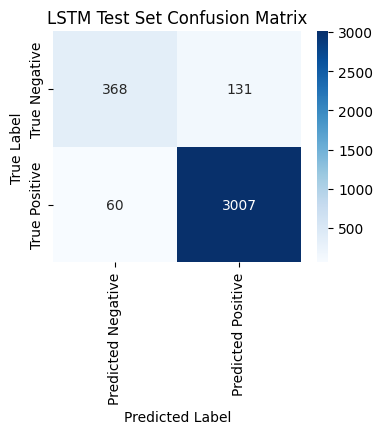

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Custom callback to compute F1 on validation data each epoch
class F1Callback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.X_val, self.y_val = val_data

    def on_epoch_end(self, epoch, logs=None):
        y_pred = (self.model.predict(self.X_val) > 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        print(f" — val_f1: {f1:.4f}")

# Split off a validation set
val_frac = 0.1
idx = int(len(X_train_pad) * (1 - val_frac))
X_tr, X_val = X_train_pad[:idx], X_train_pad[idx:]
y_tr, y_val = y_train_bin.values[:idx], y_train_bin.values[idx:]

# Train
es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lstm_model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=128,
    callbacks=[es, F1Callback((X_val, y_val))],
    verbose=2
)

# Test-set evaluation
y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype(int)
acc_lstm  = accuracy_score(y_test_bin, y_pred_lstm)
prec_lstm = precision_score(y_test_bin, y_pred_lstm)
rec_lstm  = recall_score(y_test_bin, y_pred_lstm)
f1_lstm   = f1_score(y_test_bin, y_pred_lstm)

print("\nLSTM Test Performance:")
print(f"  Accuracy : {acc_lstm:.4f}")
print(f"  Precision: {prec_lstm:.4f}")
print(f"  Recall   : {rec_lstm:.4f}")
print(f"  F1 Score : {f1_lstm:.4f}")

# Plot Confusion Matrix
cm_lstm = confusion_matrix(y_test_bin, y_pred_lstm)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title("LSTM Test Set Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [36]:
lstm_model.save("lstm_model.keras")

## 9. Deep Learning Model 2: Transformer Fine‐Tuning (BERT) with PyTorch

I’ll fine‐tune `bert-base-uncased` using Hugging Face’s PyTorch `Trainer` API:
1. Tokenize with `AutoTokenizer`
2. Build PyTorch `Dataset`s with input tensors + labels
3. Use `AutoModelForSequenceClassification`
4. Train with `Trainer` + `TrainingArguments`
5. Evaluate test‐set accuracy, precision, recall, F1



In [37]:
pip install transformers==4.27.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.3 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.4
    Uninstalling tokenizers-0.21.4:
      Successfully uninstalled tokenizers-0.21.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.55.0
    Uninstalling transformers-4.55.0:
      Successfully uninstalled transformers-4.55.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 5.0.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.27.4 which is incompatible.


In [38]:
!pip install --upgrade keras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.10.0
    Uninstalling keras-3.10.0:
      Successfully uninstalled keras-3.10.0


In [39]:
# Imports
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score

In [40]:
# Tokenization
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

train_enc = tokenizer(
    X_train.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)
test_enc = tokenizer(
    X_test.tolist(),
    truncation=True,
    padding='max_length',
    max_length=128,
    return_tensors='pt'
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [41]:
# Add your labels into the encoding dicts
train_enc['labels'] = torch.tensor(y_train_bin.values, dtype=torch.long)
test_enc['labels']  = torch.tensor(y_test_bin.values,  dtype=torch.long)

In [42]:
# Define the PyTorch Dataset wrapper once
class TorchTextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        # labels already in encodings, but ensure correct dtype
        item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

In [43]:
# Instantiate real Datasets for Trainer
train_dataset = TorchTextDataset(train_enc, y_train_bin.values)
test_dataset  = TorchTextDataset(test_enc,  y_test_bin.values)

In [44]:
# Model & TrainingArguments
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=2
)
args = TrainingArguments(
    output_dir='./bert-pytorch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    evaluation_strategy='epoch',
    logging_steps=50,
    save_total_limit=1,
    report_to=[]
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

In [45]:
# Compute-metrics
def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        'accuracy': (preds == labels).astype(float).mean().item(),
        'precision': precision_score(labels, preds),
        'recall':    recall_score(labels, preds),
        'f1':        f1_score(labels, preds)
    }

In [46]:
# Trainer: now using train_dataset & test_dataset
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.187300,0.135502,0.953449,0.968356,0.977828,0.973069
2,0.079000,0.161490,0.960460,0.971631,0.982719,0.977144
3,0.057000,0.171737,0.961021,0.975325,0.979459,0.977387


BERT (PyTorch) Test Metrics: {'eval_loss': 0.17173728346824646, 'eval_accuracy': 0.9610207515423443, 'eval_precision': 0.9753246753246754, 'eval_recall': 0.9794587544832083, 'eval_f1': 0.9773873434195542, 'eval_runtime': 23.7222, 'eval_samples_per_second': 150.323, 'eval_steps_per_second': 4.721, 'epoch': 3.0}


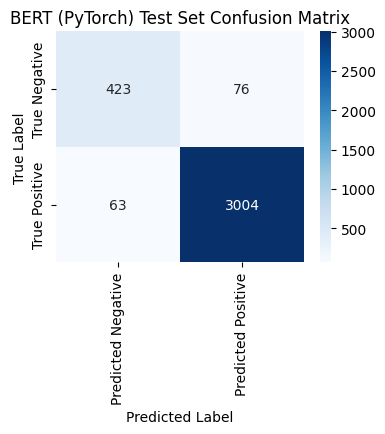

In [47]:
# Train & Evaluate
trainer.train()
metrics = trainer.evaluate()
print("BERT (PyTorch) Test Metrics:", metrics)

# Add Confusion Matrix for Sentiment
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions from the trainer's evaluation output
# The predictions are logits, so we need to get the class with the highest logit
y_pred_logits = trainer.predict(test_dataset).predictions
y_pred_bert = y_pred_logits.argmax(axis=1)

# Plot Confusion Matrix
cm_bert = confusion_matrix(test_dataset.labels, y_pred_bert)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_bert, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title("BERT (PyTorch) Test Set Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## 10. Inference: Test on Sample Reviews

Now that we’ve fine‐tuned BERT, let’s write a small helper function to run raw text through our tokenizer+model pipeline and print out predicted sentiments. We’ll test it on 5 random reviews from the held-out test set.


In [48]:
import torch
import numpy as np

def predict_sentiment(texts, tokenizer, model, max_length=128, device='cpu'):
    """
    Given a list of raw review strings, returns a list of 'positive'/'negative' predictions.
    """
    # Tokenize + encode
    enc = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )
    enc = {k: v.to(device) for k,v in enc.items()}

    # Run through model
    model.eval()
    with torch.no_grad():
        outputs = model(**enc)
        logits = outputs.logits

    # Convert logits to class labels (0=negative, 1=positive)
    preds = torch.argmax(logits, dim=-1).cpu().numpy()
    return ['positive' if p==1 else 'negative' for p in preds]

# Move model to CPU or GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Sample 5 real reviews from X_test
sample_texts = X_test.sample(5, random_state=42).tolist()
sample_labels = y_test.reset_index(drop=True).loc[[X_test.index.get_loc(i) for i in X_test.sample(5, random_state=42).index]]

# Run predictions
preds = predict_sentiment(sample_texts, tokenizer, model, device=device)

# Display
for review, true_sent, pred in zip(sample_texts, sample_labels, preds):
    print(f"Review: {review}\nTrue sentiment: {true_sent:>8}  →  Predicted: {pred}\n{'-'*80}")


Review: ok let s just face m staying fat forever s worth giving places like m huge ice cream fan mitchell s did disappoint triple rocky road salted caramel pb cup favorite pb cup looking forward bringing kids
True sentiment: positive  →  Predicted: positive
--------------------------------------------------------------------------------
Review: lavender ice cream need fleur sel absolutely excellent fleur sel ice creams ve sweet caramel salt kick makes actual fleur sel theirs salt came caramel goodness tried lime basil tastes like frozen mojito isn t bad thing wait come try flavors
True sentiment: positive  →  Predicted: positive
--------------------------------------------------------------------------------
Review: love doughnuts doughnut aficionado good opinion dense note flavored lack good dough icing ratio didn t taste fresh morning feel like doughnuts taste fresh lunchtime worst doughnuts ve aren t worth price tag isn t worth special trip ve far better doughnuts las vegas like rea

## Weak-Labeling via Keyword Heuristics

In [49]:
# Drop any reviews with missing text
df = df.dropna(subset=['review_text']).reset_index(drop=True)

In [50]:
# Define or import label_aspects_loose()
aspect_labels = df['review_text'].apply(label_aspects)
df_aspect    = pd.concat([df, pd.DataFrame(list(aspect_labels))], axis=1)

In [51]:
print(df_aspect[['Food','Service','Ambiance','Value']].sum())

for asp in ['Food','Service','Ambiance','Value']:
    print(f"Sample for {asp}=1:")
    display(df_aspect[df_aspect[asp]==1]['review_text'].sample(3, random_state=42))


Food        12073
Service      4984
Ambiance     1400
Value        4208
dtype: int64
Sample for Food=1:


,review_text
5208,"Despite all the reviews, I did not try a macar..."
7542,I came into sprinkles today at the Las Vegas l...
8442,"Took a while to find, it's hidden and it would..."


Sample for Service=1:


,review_text
5902,We visited this place on our visit to Arizona ...
10203,Best ice cream around. Great choices. All the ...
1735,This is probably the best ice cream I have eve...


Sample for Ambiance=1:


,review_text
3958,Most excellent bakery. Opened 24/7 for anyone'...
3823,"As a coffee addict, I can be pretty critical o..."
1580,I love the decor and antique finds! The cakes ...


Sample for Value=1:


,review_text
7351,"Okay, so the first time I've ever heard of Spr..."
14890,Amazing donuts for affordable prices. I went i...
10968,Love this place! The food is amazing and the p...


### 11. Deep Model 1: Multi–Task LSTM for Aspect & Sentiment

Ie’ll repurpose our LSTM pipeline so that it predicts:

1. A **4‐way multi‐label** “aspect presence” head  
2. A **binary** “overall sentiment” head  

Loss is the sum of four binary‐crossentropy + one binary‐crossentropy.  


In [52]:
#  Prepare sequences and labels
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Hyperparameters
MAX_VOCAB_SIZE      = 20000
MAX_SEQUENCE_LENGTH = 100
EMBED_DIM           = 100

# Tokenize on raw review_text
tok = Tokenizer(num_words=MAX_VOCAB_SIZE)
tok.fit_on_texts(df_aspect['review_text'])
seqs = tok.texts_to_sequences(df_aspect['review_text'])
X_seq = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Build aspect label matrix & sentiment vector
Y_aspect    = df_aspect[['Food','Service','Ambiance','Value']].values.astype(float)
Y_sentiment = (df_aspect['sentiment']=='positive').astype(float).values

# Train/test split
from sklearn.model_selection import train_test_split
X_tr, X_val, A_tr, A_val, S_tr, S_val = train_test_split(
    X_seq, Y_aspect, Y_sentiment, test_size=0.2, random_state=42, stratify=Y_sentiment
)


In [53]:
# Build & compile the multi‐task LSTM model
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense
from tensorflow.keras.models import Model

# Inputs
inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_seq')
x   = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_SEQUENCE_LENGTH)(inp)
x   = Bidirectional(LSTM(128, return_sequences=False))(x)
x   = Dropout(0.3)(x)

# Aspect head (4‐label sigmoid)
asp_out = Dense(4, activation='sigmoid', name='aspect_output')(x)

# Sentiment head (binary sigmoid)
sen_out = Dense(1, activation='sigmoid', name='sentiment_output')(x)

model_lstm = Model(inputs=inp, outputs=[asp_out, sen_out])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'aspect_output':'binary_crossentropy','sentiment_output':'binary_crossentropy'},
    metrics={'aspect_output':'accuracy','sentiment_output':'accuracy'}
)
model_lstm.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_seq           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 100)  │  2,000,000 │ input_seq[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    234,496 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspect_output       │ (None, 4)         │      1,028 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │        257 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,235,781 (8.53 MB)

 Trainable params: 2,235,781 (8.53 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
# Train the LSTM
history_lstm = model_lstm.fit(
    X_tr,
    {'aspect_output':A_tr, 'sentiment_output':S_tr},
    validation_data=(X_val, {'aspect_output':A_val, 'sentiment_output':S_val}),
    epochs=5,
    batch_size=64
)


Epoch 1/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - aspect_output_accuracy: 0.8284 - aspect_output_loss: 0.5286 - loss: 0.9214 - sentiment_output_accuracy: 0.8642 - sentiment_output_loss: 0.3928 - val_aspect_output_accuracy: 0.8446 - val_aspect_output_loss: 0.4603 - val_loss: 0.6671 - val_sentiment_output_accuracy: 0.9226 - val_sentiment_output_loss: 0.2072
Epoch 2/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - aspect_output_accuracy: 0.8134 - aspect_output_loss: 0.4510 - loss: 0.6051 - sentiment_output_accuracy: 0.9460 - sentiment_output_loss: 0.1541 - val_aspect_output_accuracy: 0.8345 - val_aspect_output_loss: 0.4748 - val_loss: 0.6365 - val_sentiment_output_accuracy: 0.9431 - val_sentiment_output_loss: 0.1619
Epoch 3/5
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - aspect_output_accuracy: 0.7917 - aspect_output_loss: 0.4438 - loss: 0.5347 - sentiment_output_accuracy: 0.9678 - sentiment_output_loss: 0.0909 - val_aspect_output_accuracy: 0.7434 - val_aspect_output_loss: 0.3775 - val_los

Train/Validation split performed.

Multi-Task LSTM model built and compiled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_seq           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 100, 100)  │  2,000,000 │ input_seq[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 256)       │    234,496 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ bidirectional_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspect_output       │ (None, 4)         │      1,028 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │        257 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,235,781 (8.53 MB)

 Trainable params: 2,235,781 (8.53 MB)

 Non-trainable params: 0 (0.00 B)


Training Multi-Task LSTM model...
Multi-Task LSTM model training finished.

--- Food ---
Food Accuracy: 0.9607
Food Precision: 0.9878
Food Recall: 0.9529
Food F1: 0.9700


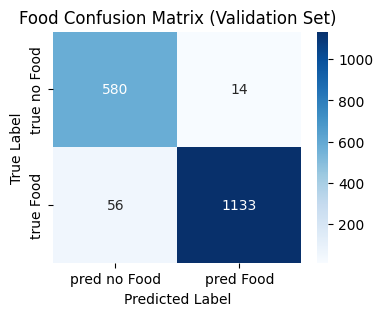


--- Service ---
Service Accuracy: 0.9635
Service Precision: 0.9932
Service Recall: 0.8758
Service F1: 0.9308


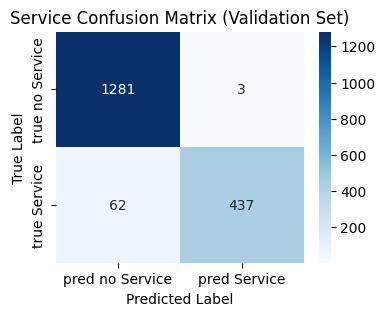


--- Ambiance ---
Ambiance Accuracy: 0.9181
Ambiance Precision: 0.0000
Ambiance Recall: 0.0000
Ambiance F1: 0.0000


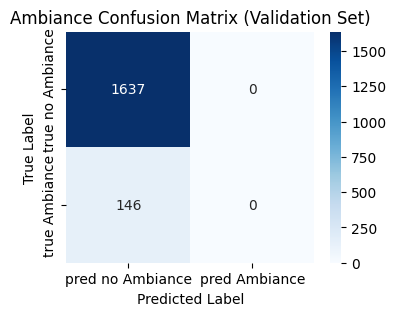


--- Value ---
Value Accuracy: 0.7504
Value Precision: 0.0000
Value Recall: 0.0000
Value F1: 0.0000


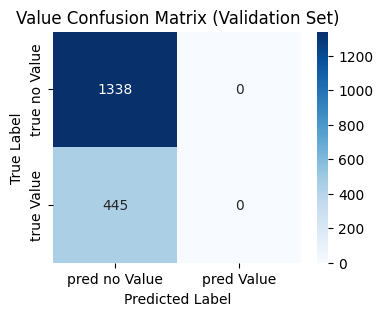


--- Sentiment ---
Sentiment Accuracy: 0.9389
Sentiment Precision: 0.9472
Sentiment Recall: 0.9837
Sentiment F1: 0.9651


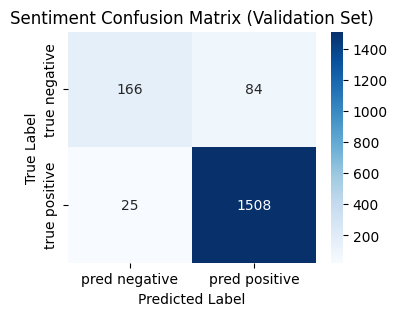

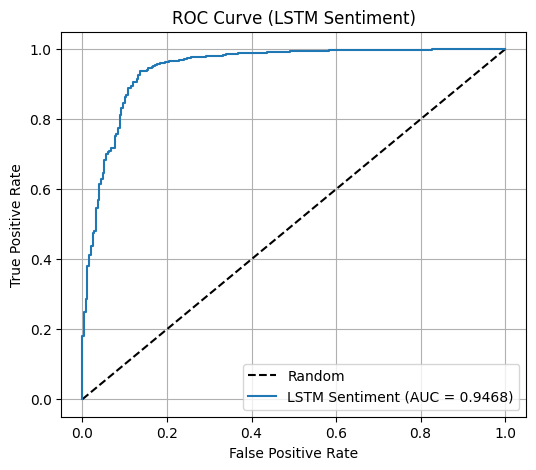

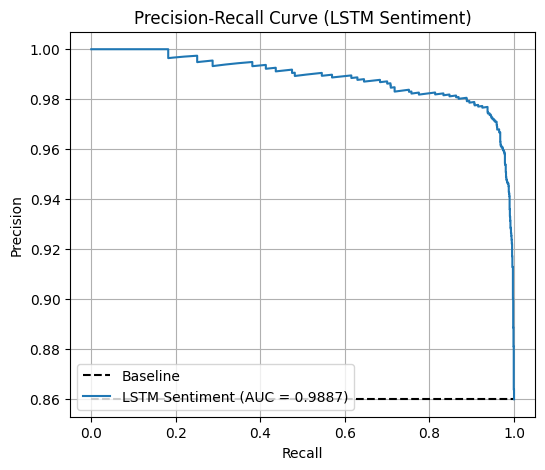

LSTM Sentiment: ROC-AUC = 0.9468, PR-AUC = 0.9887


In [57]:
# Evaluate aspect‐wise F1 & overall sentiment F1
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for array operations
import tensorflow as tf # Import tensorflow to build the model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense # Import layers
from tensorflow.keras.models import Model # Import Model

# --- Build & compile the multi‐task LSTM model (Copied from cells jANVEbqKebNB and bcUFXV8BefV5) ---
# Assuming MAX_SEQUENCE_LENGTH, MAX_VOCAB_SIZE, EMBED_DIM, X_val, A_val, S_val, X_tr, A_tr, S_tr are defined

# Inputs
inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_seq')
x   = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_SEQUENCE_LENGTH)(inp)
x   = Bidirectional(LSTM(128, return_sequences=False))(x)
x   = Dropout(0.3)(x)

# Aspect head (4‐label sigmoid)
asp_out = Dense(4, activation='sigmoid', name='aspect_output')(x)

# Sentiment head (binary sigmoid)
sen_out = Dense(1, activation='sigmoid', name='sentiment_output')(x)

model_lstm = Model(inputs=inp, outputs=[asp_out, sen_out])

model_lstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss={'aspect_output':'binary_crossentropy','sentiment_output':'binary_crossentropy'},
    metrics={'aspect_output':'accuracy','sentiment_output':'accuracy'}
)
print("Multi-Task LSTM model built and compiled.")
model_lstm.summary()

# Train the LSTM
print("\nTraining Multi-Task LSTM model...")
history_lstm = model_lstm.fit(
    X_tr,
    {'aspect_output':A_tr, 'sentiment_output':S_tr},
    validation_data=(X_val, {'aspect_output':A_val, 'sentiment_output':S_val}),
    epochs=5,
    batch_size=64,
    verbose=0 # Reduce verbosity for integration
)
print("Multi-Task LSTM model training finished.")

# --- End of Build and Compile ---


# Predict on validation set
A_pred, S_pred = model_lstm.predict(X_val, verbose=0) # Add verbose=0 to suppress prediction progress output
A_bin = (A_pred>0.5).astype(int)
S_bin = (S_pred>0.5).astype(int)

# Aspect Metrics and Confusion Matrices
aspect_names = ['Food','Service','Ambiance','Value']
for i, asp in enumerate(aspect_names):
    print(f"\n--- {asp} ---")
    acc_asp = accuracy_score(A_val[:,i], A_bin[:,i])
    prec_asp = precision_score(A_val[:,i], A_bin[:,i], zero_division=0) # Add zero_division=0 to handle cases with no positive predictions
    rec_asp = recall_score(A_val[:,i], A_bin[:,i], zero_division=0)
    f1_asp = f1_score(A_val[:,i], A_bin[:,i], zero_division=0)
    print(f"{asp} Accuracy: {acc_asp:.4f}")
    print(f"{asp} Precision: {prec_asp:.4f}")
    print(f"{asp} Recall: {rec_asp:.4f}")
    print(f"{asp} F1: {f1_asp:.4f}")


    # Confusion Matrix for each aspect
    cm_asp = confusion_matrix(A_val[:,i], A_bin[:,i])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_asp, annot=True, fmt="d", cmap="Blues",
                xticklabels=[f"pred no {asp}", f"pred {asp}"],
                yticklabels=[f"true no {asp}", f"true {asp}"])
    plt.title(f"{asp} Confusion Matrix (Validation Set)")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


# Sentiment Metrics and Confusion Matrix
print("\n--- Sentiment ---")
acc_sent = accuracy_score(S_val, S_bin)
prec_sent = precision_score(S_val, S_bin, zero_division=0)
rec_sent = recall_score(S_val, S_bin, zero_division=0)
f1_sent = f1_score(S_val, S_bin, zero_division=0)
print(f"Sentiment Accuracy: {acc_sent:.4f}")
print(f"Sentiment Precision: {prec_sent:.4f}")
print(f"Sentiment Recall: {rec_sent:.4f}")
print(f"Sentiment F1: {f1_sent:.4f}")


# Confusion Matrix for Sentiment
cm_sent = confusion_matrix(S_val, S_bin)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_sent, annot=True, fmt="d", cmap="Blues",
            xticklabels=["pred negative", "pred positive"],
            yticklabels=["true negative", "true positive"])
plt.title("Sentiment Confusion Matrix (Validation Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# --- Add ROC and PR Curves for Sentiment ---
try:
    # S_pred contains the sentiment probabilities from model_lstm.predict
    lstm_sentiment_probs = S_pred.flatten() # Make it 1D
    y_true_sentiment = S_val # True labels for sentiment

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true_sentiment, lstm_sentiment_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], 'k--', label='Random') # Baseline random model
    plt.plot(fpr, tpr, label=f'LSTM Sentiment (AUC = {roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (LSTM Sentiment)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(y_true_sentiment, lstm_sentiment_probs)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 5))
    positive_proportion = np.mean(y_true_sentiment)
    plt.plot([0, 1], [positive_proportion, positive_proportion], 'k--', label='Baseline')
    plt.plot(recall, precision, label=f'LSTM Sentiment (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (LSTM Sentiment)')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # Print AUC Scores
    print(f"LSTM Sentiment: ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}")

except Exception as e:
    print(f"Could not generate ROC/PR curves for Sentiment: {e}")

### 12. Deep Model 2: Multi–Task BERT for Aspect & Sentiment

Now I’ll fine-tune `bert-base-uncased` with two heads:
- **Aspect head:** 4‐unit sigmoid  
- **Sentiment head:** 1‐unit sigmoid  

We’ll use the PyTorch `Trainer` API.


In [59]:
# Imports & tokenizer
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_score, recall_score, f1_score

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [60]:
# Tokenize & build PyTorch dataset
class AspectSentimentDataset(torch.utils.data.Dataset):
    def __init__(self, texts, aspect_labels, sentiment_labels, tokenizer, max_length=128):
        self.enc = tokenizer(
            texts,
            truncation=True,
            padding='max_length',
            max_length=max_length,
            return_tensors='pt'
        )
        self.aspects   = torch.tensor(aspect_labels,   dtype=torch.float)
        self.sentiment = torch.tensor(sentiment_labels, dtype=torch.float)

    def __len__(self):
        return len(self.sentiment)

    def __getitem__(self, idx):
        item = {k:v[idx] for k,v in self.enc.items()}
        item['labels'] = torch.cat([self.aspects[idx], self.sentiment[idx].unsqueeze(0)], dim=0)
        return item

# Build train & eval splits
X_train_txt, X_val_txt, A_tr, A_val, S_tr, S_val = train_test_split(
    df_aspect['review_text'].tolist(),
    df_aspect[['Food','Service','Ambiance','Value']].values,
    (df_aspect['sentiment']=='positive').astype(int).values,
    test_size=0.2, random_state=42, stratify=(df_aspect['sentiment']=='positive')
)

train_ds = AspectSentimentDataset(X_train_txt, A_tr, S_tr, tokenizer)
val_ds   = AspectSentimentDataset(X_val_txt,   A_val, S_val, tokenizer)


In [61]:
# Load model & adapt the classification head
from transformers import BertConfig, BertModel
from torch import nn

config = BertConfig.from_pretrained(
    'bert-base-uncased',
    num_labels=5,            # 4 aspects + 1 sentiment
    problem_type="multi_label_classification"
)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

# TrainingArguments
args = TrainingArguments(
    output_dir='./bert-aspect-sentiment',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    evaluation_strategy='epoch',
    logging_steps=50,
    save_total_limit=1,
    report_to=[]
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the check

In [62]:
# Compute metrics for 5‐dim output
def compute_metrics(p):
    logits = p.predictions
    labels = p.label_ids
    # split
    asp_logits = logits[:,:4]
    sen_logits = logits[:,4]
    asp_preds  = (torch.sigmoid(torch.tensor(asp_logits))>0.5).numpy().astype(int)
    sen_preds  = (torch.sigmoid(torch.tensor(sen_logits))>0.5).numpy().astype(int)

    # aspect‐wise F1
    asp_f1s = [f1_score(labels[:,i], asp_preds[:,i]) for i in range(4)]
    sen_f1  = f1_score(labels[:,4], sen_preds)

    metrics = {f"F1_{asp}":asp_f1s[i] for i,asp in enumerate(['Food','Service','Ambiance','Value'])}
    metrics["F1_sentiment"] = sen_f1
    return metrics


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy Food,Precision Food,Recall Food,F1 Food,Accuracy Service,Precision Service,Recall Service,F1 Service,Accuracy Ambiance,Precision Ambiance,Recall Ambiance,F1 Ambiance,Accuracy Value,Precision Value,Recall Value,F1 Value,Accuracy Sentiment,Precision Sentiment,Recall Sentiment,F1 Sentiment
1,0.107800,0.106212,0.968031,0.980566,0.971536,0.976030,0.961862,1.000000,0.866797,0.928646,0.990466,1.000000,0.876812,0.934363,0.945036,0.992515,0.776347,0.871222,0.958497,0.984401,0.967069,0.975658
2,0.082800,0.093521,0.971397,0.985975,0.971118,0.978490,0.961862,0.998873,0.867777,0.928721,0.990466,1.000000,0.876812,0.934363,0.943915,0.983728,0.778689,0.869281,0.967190,0.981083,0.980763,0.980923
3,0.064500,0.095818,0.972238,0.980688,0.977815,0.979250,0.960179,0.984564,0.874633,0.926349,0.989905,0.983871,0.884058,0.931298,0.941110,0.965318,0.782201,0.864166,0.971397,0.979929,0.986958,0.983431


{'eval_loss': 0.0958184003829956, 'eval_Accuracy_Food': 0.9722378014582165, 'eval_Precision_Food': 0.980688497061293, 'eval_Recall_Food': 0.9778149853495186, 'eval_F1_Food': 0.9792496332005869, 'eval_Accuracy_Service': 0.9601794727986539, 'eval_Precision_Service': 0.9845644983461963, 'eval_Recall_Service': 0.8746327130264446, 'eval_F1_Service': 0.9263485477178424, 'eval_Accuracy_Ambiance': 0.9899046550757151, 'eval_Precision_Ambiance': 0.9838709677419355, 'eval_Recall_Ambiance': 0.8840579710144928, 'eval_F1_Ambiance': 0.9312977099236641, 'eval_Accuracy_Value': 0.9411104879416713, 'eval_Precision_Value': 0.9653179190751445, 'eval_Recall_Value': 0.7822014051522248, 'eval_F1_Value': 0.8641655886157826, 'eval_Accuracy_sentiment': 0.971396522714526, 'eval_Precision_sentiment': 0.9799287795403043, 'eval_Recall_sentiment': 0.986957939354418, 'eval_F1_sentiment': 0.9834307992202729, 'eval_runtime': 23.979, 'eval_samples_per_second': 148.713, 'eval_steps_per_second': 4.671, 'epoch': 3.0}


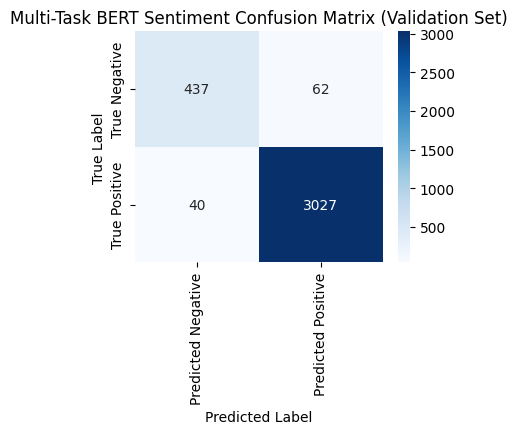


Multi-Task BERT Sentiment Classification Report (Validation Set):
              precision    recall  f1-score   support

    negative       0.92      0.88      0.90       499
    positive       0.98      0.99      0.98      3067

    accuracy                           0.97      3566
   macro avg       0.95      0.93      0.94      3566
weighted avg       0.97      0.97      0.97      3566



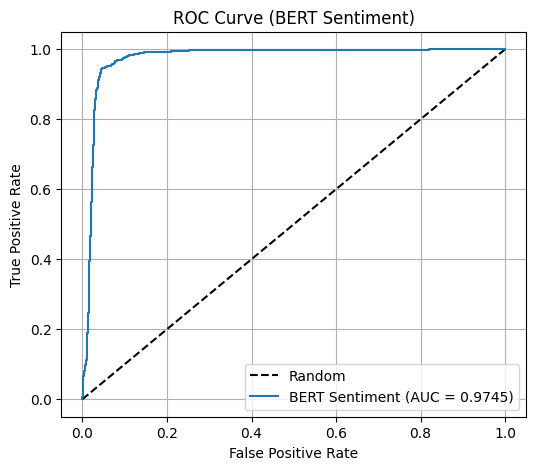

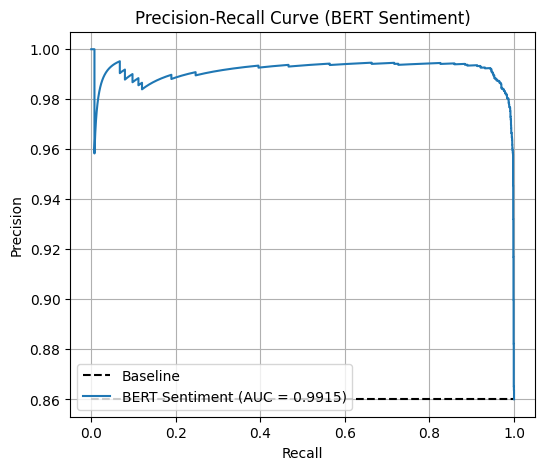

BERT Sentiment: ROC-AUC = 0.9745, PR-AUC = 0.9915

Note on AUC and Calibration:
AUC is a threshold-agnostic metric that evaluates the model's ability to rank positive
instances higher than negative ones across all possible thresholds.
The calibrated thresholds determined in cell CjMb4Z3ufV-A
are used to select a specific operating point for classification metrics (like Accuracy, F1)
and the confusion matrix, not for calculating AUC.


In [63]:
# Trainer & train
def compute_metrics(p):
    logits = p.predictions
    labels = p.label_ids
    # split
    asp_logits = logits[:,:4]
    sen_logits = logits[:,4]

    # Apply sigmoid to get probabilities for multi-label aspects
    asp_probs = torch.sigmoid(torch.tensor(asp_logits))
    asp_preds = (asp_probs > 0.5).numpy().astype(int)

    # Apply sigmoid to get probability for binary sentiment
    sen_probs = torch.sigmoid(torch.tensor(sen_logits))
    sen_preds = (sen_probs > 0.5).numpy().astype(int)


    # Aspect metrics (Accuracy, Precision, Recall, F1 for each aspect)
    aspect_names = ['Food','Service','Ambiance','Value']
    metrics = {}
    for i, asp in enumerate(aspect_names):
        # Ensure labels are integers for accuracy/precision/recall
        true_labels = labels[:, i].astype(int)
        pred_labels = asp_preds[:, i].astype(int)

        metrics[f"Accuracy_{asp}"]  = accuracy_score(true_labels, pred_labels)
        metrics[f"Precision_{asp}"] = precision_score(true_labels, pred_labels, zero_division=0)
        metrics[f"Recall_{asp}"]    = recall_score(true_labels, pred_labels, zero_division=0)
        metrics[f"F1_{asp}"]        = f1_score(true_labels, pred_labels, zero_division=0)


    # Sentiment metrics (Accuracy, Precision, Recall, F1)
    # Ensure labels are integers for accuracy/precision/recall
    true_sentiment_labels = labels[:, 4].astype(int)
    pred_sentiment_labels = sen_preds.astype(int)

    metrics["Accuracy_sentiment"]  = accuracy_score(true_sentiment_labels, pred_sentiment_labels)
    metrics["Precision_sentiment"] = precision_score(true_sentiment_labels, pred_sentiment_labels, zero_division=0)
    metrics["Recall_sentiment"]    = recall_score(true_sentiment_labels, pred_sentiment_labels, zero_division=0) # Corrected typo
    metrics["F1_sentiment"]        = f1_score(true_sentiment_labels, pred_sentiment_labels, zero_division=0)

    return metrics


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)
trainer.train()
metrics = trainer.evaluate()
print(metrics)

# --- Add Confusion Matrix and Classification Report for Sentiment (using trainer.predict) ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, roc_auc_score
import torch
import numpy as np

# Use trainer.predict to get predictions and labels for the full validation set
predictions_output = trainer.predict(val_ds)
y_pred_logits = predictions_output.predictions
y_true_labels = predictions_output.label_ids

# Get sentiment predictions (last column of logits)
sentiment_logits = y_pred_logits[:, 4]

# Apply sigmoid to get probabilities and get the predicted class (0 or 1)
sentiment_probs = torch.sigmoid(torch.tensor(sentiment_logits))
all_sentiment_preds = (sentiment_probs > 0.5).int().cpu().numpy()

# Get true sentiment labels (last column of true labels)
all_sentiment_labels = y_true_labels[:, 4].astype(int)

# Calculate and plot the confusion matrix
cm_full_bert_sentiment = confusion_matrix(all_sentiment_labels, all_sentiment_preds)

plt.figure(figsize=(4, 3))
sns.heatmap(cm_full_bert_sentiment, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.title("Multi-Task BERT Sentiment Confusion Matrix (Validation Set)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Print the classification report
print("\nMulti-Task BERT Sentiment Classification Report (Validation Set):")
print(classification_report(all_sentiment_labels, all_sentiment_preds, target_names=["negative", "positive"], zero_division=0))


# --- Add ROC and PR Curves for Sentiment ---
try:
    # bert_sentiment_probs is already calculated above
    # all_sentiment_labels is already calculated above

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_sentiment_labels, sentiment_probs.cpu().numpy()) # Use probabilities for ROC curve
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot([0, 1], [0, 1], 'k--', label='Random') # Baseline random model
    plt.plot(fpr, tpr, label=f'BERT Sentiment (AUC = {roc_auc:.4f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (BERT Sentiment)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    # PR Curve
    precision, recall, _ = precision_recall_curve(all_sentiment_labels, sentiment_probs.cpu().numpy()) # Use probabilities for PR curve
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(6, 5))
    positive_proportion = np.mean(all_sentiment_labels)
    plt.plot([0, 1], [positive_proportion, positive_proportion], 'k--', label='Baseline')
    plt.plot(recall, precision, label=f'BERT Sentiment (AUC = {pr_auc:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (BERT Sentiment)')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

    # Print AUC Scores
    print(f"BERT Sentiment: ROC-AUC = {roc_auc:.4f}, PR-AUC = {pr_auc:.4f}")

    print("\nNote on AUC and Calibration:")
    print("AUC is a threshold-agnostic metric that evaluates the model's ability to rank positive")
    print("instances higher than negative ones across all possible thresholds.")
    print("The calibrated thresholds (best_thr_pr, best_thr_neg) determined in cell CjMb4Z3ufV-A")
    print("are used to select a specific operating point for classification metrics (like Accuracy, F1)")
    print("and the confusion matrix, not for calculating AUC.")


except Exception as e:
    print(f"Could not generate ROC/PR curves for BERT Sentiment: {e}")

In [64]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# make sure your model & tokenizer are loaded, on the right device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# --- Calculate best_thr_pr and best_thr_neg (copied from cell OCDPxs5U4Gpr) ---
# batched inference to avoid OOM
def batched_predict_logits_sentiment(texts, batch_size=32):
    all_logits = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + 32]
        enc = tokenizer(
            batch,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits[:, 4]  # sentiment head
        all_logits.append(logits.cpu().numpy())
    return np.concatenate(all_logits)

# Assuming X_val_txt and S_val are available from previous cells
# If not, you might need to re-run data preparation cells
all_logits_val = batched_predict_logits_sentiment(X_val_txt) # Use validation data for threshold calibration
probs_pos_val  = 1 / (1 + np.exp(-all_logits_val))           # sigmoid → P(pos)
probs_neg_val  = 1 - probs_pos_val                           # P(neg)

# Calculate best_thr_pr for the positive class
y_true_pos_val = S_val # True labels for the positive class on validation set
prec_p_val, rec_p_val, thr_p_val = precision_recall_curve(y_true_pos_val, probs_pos_val)
f1_scores_p_val = 2 * prec_p_val * rec_p_val / (prec_p_val + rec_p_val + 1e-8)
best_idx_p_val = np.nanargmax(f1_scores_p_val)
best_thr_pr = thr_p_val[best_idx_p_val]
print(f"Optimal positive-class probability threshold (calibrated on validation set): {best_thr_pr:.4f}")

# Calculate best_thr_neg for the negative class
y_true_neg_val = 1 - y_true_pos_val # True labels for the negative class on validation set (1 for true negative)
prec_n_val, rec_n_val, thr_n_val = precision_recall_curve(y_true_neg_val, probs_neg_val)
f1_scores_n_val = 2 * prec_n_val * rec_n_val / (prec_n_val + rec_n_val + 1e-8)
best_idx_n_val = np.nanargmax(f1_scores_n_val)
best_thr_neg = thr_n_val[best_idx_n_val]
print(f"Optimal negative-class probability threshold (calibrated on validation set): {best_thr_neg:.4f}")
# --- End of threshold calculation ---


def predict_aspect_sentiment_bert_dual(
    texts,
    aspect_thr: float = 0.5,
    pos_thr: float = best_thr_pr,
    neg_thr: float = best_thr_neg
):
    all_logits = []
    # batch in chunks of 32
    for i in range(0, len(texts), 32):
        batch = texts[i : i + 32]
        enc = tokenizer(
          batch,
          truncation=True,
          padding="max_length",
          max_length=128,
          return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits.cpu().numpy()  # shape (batch_size, 5)
        all_logits.append(logits)

    all_logits = np.vstack(all_logits)  # now (n_texts,5)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid

    # aspect predictions at 0.5
    aspect_preds = (probs[:, :4] > aspect_thr).astype(int)

    # dual‐threshold for sentiment
    p_pos = probs[:, 4]
    sent_preds = np.where(
      p_pos >= pos_thr, 1,
      np.where(p_pos <= neg_thr, 0, (p_pos > 0.5).astype(int))
    )

    return aspect_preds, sent_preds

# --- pick 5 true negatives + 5 true positives from your TEST set ---
y_true_sent_bin = np.array([1 if lbl=="positive" else 0 for lbl in y_test])
texts  = np.array(X_test)

neg_texts = texts[y_true_sent_bin == 0][:5].tolist()
pos_texts = texts[y_true_sent_bin == 1][:5].tolist()
smoke_texts = neg_texts + pos_texts

# Get true sentiment and aspect labels for the smoke samples
# Assuming asp_test is available and its index aligns with X_test
smoke_indices_in_X_test = [X_test.tolist().index(text) for text in smoke_texts]
# Use .iloc to access by integer position instead of .loc which expects index labels
smoke_true_aspects = asp_test.iloc[smoke_indices_in_X_test].values
smoke_true_sent = y_test_bin.iloc[smoke_indices_in_X_test].values


assert len(smoke_texts)==10, "Oops, your smoke_texts is empty or too small"
assert len(smoke_true_aspects) == len(smoke_texts), "Mismatch between smoke texts and true aspect labels"
assert len(smoke_true_sent) == len(smoke_texts), "Mismatch between smoke texts and true sentiment labels"


print("=== True Labels (5 neg → 5 pos) ===")
for txt, lbl in zip(smoke_texts, smoke_true_sent):
    print(f" → ({'neg' if lbl==0 else 'pos'}) {txt}")

# run the dual‐threshold inference
asp_smoke, sent_smoke = predict_aspect_sentiment_bert_dual(
    smoke_texts,
    aspect_thr=0.5,
    pos_thr=best_thr_pr,
    neg_thr=best_thr_neg
)

print("\n=== Model Predictions on Smoke Samples ===")
for txt, a_pred, s_pred in zip(smoke_texts, asp_smoke, sent_smoke):
    asp_dict = dict(zip(['Food','Service','Ambiance','Value'], a_pred))
    print(f" • Aspects: {asp_dict}    Sentiment: {'pos' if s_pred else 'neg'}   {txt}")



Optimal positive-class probability threshold (calibrated on validation set): 0.3080
Optimal negative-class probability threshold (calibrated on validation set): 0.5270
=== True Labels (5 neg → 5 pos) ===
 → (neg) waited line minutes girl working crepe maybe minutes text messages coffee breaks people literally got line didn t just wisdom teeth need soft food horrible service
 → (neg) donuts probable awesome able try times donuts sold just aware relatively good chance donut shop donuts sure good fool shame fool twice shame fool time just moron coming know just guy wants donut shop donuts
 → (neg) strawberry wasn t good tasted old like carton comes m ice cream lover eat ice cream just couldn t finish
 → (neg) terrible customer service treats good places city sweets money happy work downtown visited shop numerous times pleasant experience staff teenagers working busy phones care helping visited minutes close immediately met annoyance clear girl counter didn t want help wanted leave left ha

## 13. Inference Check: LSTM vs. BERT

Let’s grab 5 random test‐set reviews and see what each model predicts for:
- **Aspect presence** (Food, Service, Ambiance, Value)  
- **Overall sentiment** (positive/negative)  


In [65]:
# Sample 5 raw test reviews
import random
random.seed(42)

# If you have X_test_txt and y_test already defined:
sample_idxs  = random.sample(range(len(X_val_txt)), 5)
sample_texts = [X_val_txt[i] for i in sample_idxs]
true_sents   = [ 'positive' if S_val[i]==1 else 'negative' for i in sample_idxs ]
true_aspects = [ dict(zip(['Food','Service','Ambiance','Value'], A_val[i])) for i in sample_idxs ]

for i, txt in enumerate(sample_texts):
    print(f"--- Review #{i+1} ---")
    print(txt[:200] + ("…" if len(txt)>200 else ""))
    print("True Aspects:", true_aspects[i])
    print("True Sentiment:", true_sents[i])
    print()


--- Review #1 ---
For all of us weary from blah soft-serv: Despair no more. This ice cream is made in house and is divine. We ordered only a pippin-sized Banana Split (per menu) and split it with four adults after a la…
True Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}
True Sentiment: positive

--- Review #2 ---
One thing that makes this place special is I think the way the market is great. They focus on having different items on certain days so people want to try all the different things here. One thing that…
True Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}
True Sentiment: positive

--- Review #3 ---
We have some happy kids (and adults)!!!! This is the ultimate sweet shop. The ice cream is amazing, but the cookies also rock. I love the salted chocolate chip! Great outdoor seating to make you feel …
True Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np

In [66]:
import random
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Pick 3 positives, 2 negatives
pos_idxs = [i for i, s in enumerate(S_val) if s==1]
neg_idxs = [i for i, s in enumerate(S_val) if s==0]

random.seed(42)
sample_pos = random.sample(pos_idxs, 3)
sample_neg = random.sample(neg_idxs, 2)
sample_idxs = sample_pos + sample_neg
random.shuffle(sample_idxs)

# Build your sample_texts and true labels
sample_texts = [X_val_txt[i] for i in sample_idxs]
true_sents   = ['positive' if S_val[i]==1 else 'negative' for i in sample_idxs]

print("=== True Sentiments ===")
for i, txt in enumerate(sample_texts):
    print(f"\n#{i+1}:", txt[:100] + "…")
    print("  True Sentiment:", true_sents[i])

# Now run LSTM inference on those exact same texts
seqs = tok.texts_to_sequences(sample_texts)
X_samp_seq = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

asp_probs, sen_probs = model_lstm.predict(X_samp_seq, verbose=0)
asp_pred = (asp_probs > 0.5).astype(int)
sen_pred = (sen_probs > 0.5).astype(int)

print("\n=== LSTM Predictions ===")
for i, txt in enumerate(sample_texts):
    asp_dict = dict(zip(['Food','Service','Ambiance','Value'], asp_pred[i]))
    sent_str = 'positive' if sen_pred[i][0]==1 else 'negative'
    print(f"\n#{i+1}:", txt[:100] + "…")
    print("  Pred Aspects: {0}".format(asp_dict))
    print("  Pred Sentiment:", sent_str, f"(p={sen_probs[i][0]:.3f})")


=== True Sentiments ===

#1: Went here for the 1st time tonight. I ordered a turtle tornado. It was excellent. TONS of pecans and…
  True Sentiment: negative

#2: I can't say enough about this place! Definitely stop in if your in downtown Vegas...you will not reg…
  True Sentiment: positive

#3: Yum! Had the cookies and mint. Definitely delicious. I was a little surprised by the lack of flavors…
  True Sentiment: positive

#4: Ridiculously priced. A scoop of ice cream was so small. Macaroon and toasted marshmallow were very g…
  True Sentiment: negative

#5: Amazing to find a 24 hr cafe serving up sweets, coffees, and sandwiches! This is rare when I've only…
  True Sentiment: positive

=== LSTM Predictions ===

#1: Went here for the 1st time tonight. I ordered a turtle tornado. It was excellent. TONS of pecans and…
  Pred Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}
  Pred Sentiment: positive (p=0.643)

#2: I can't say enough abo

In [75]:
import numpy as np
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer
import tensorflow as tf # Import tensorflow for model definition
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense # Import layers
from tensorflow.keras.models import Model # Import Model
from sklearn.model_selection import train_test_split # Import train_test_split
import pandas as pd # Import pandas for DataFrame operations
import re # Import re for cleaning text
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS # Import stop words

# --- Data Loading, Cleaning, and Weak-Labeling (Copied from previous cells) ---
# Assuming the CSV file is available at '/content/Yelp Restaurant Reviews.csv'

# Load raw CSV
df = pd.read_csv('/content/Yelp Restaurant Reviews.csv')

# Standardize column names
df.columns = [c.strip().lower().replace(' ', '_') for c in df.columns]

# Filter & label overall sentiment
# drop 3-star (neutral) reviews
df = df[df.rating != 3].copy()
# binary sentiment: 4–5 → positive, 1–2 → negative
df['sentiment'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# Define a reusable function to clean each review
def clean_text(text: str) -> str:
    """
    1) lowercase
    2) remove HTML tags
    3) remove non-letter characters
    4) drop English stop‐words
    """
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)         # strip HTML
    text = re.sub(r'[^a-z\s]', ' ', text)        # keep only letters & spaces
    tokens = text.split()
    tokens = [tok for tok in tokens if tok not in ENGLISH_STOP_WORDS]
    return ' '.join(tokens)

# Apply cleaning
df['cleaned_review'] = df['review_text'].fillna('').apply(clean_text)

# Define aspect keywords (Copied from cell NuMbNujwtKiG)
aspect_keywords = {
    'Food':    [r'\b(?:cream|ice[- ]?cream|chocolate|cake|flavor\w*|dessert|pizza|burger)\b'],
    'Service': [r'\b(?:staff|service|waiter\w*|friendly|rude)\b'],
    'Ambiance':[r'\b(?:atmosph\w*|ambian\w*|decor|music|noise|vibe)\b'],
    'Value':   [r'\b(?:price\w*|cost|cheap|expens\w*|worth|value|portion)\b'],
}

def count_aspects(texts, patterns):
    """Return an (n_samples, 4) numpy array of aspect‐mention counts."""
    counts = np.zeros((len(texts), len(patterns)), dtype=int)
    for i, txt in enumerate(texts):
        for j, (asp, pats) in enumerate(patterns.items()):
            total = 0
            for pat in pats:
                total += len(re.findall(pat, txt, flags=re.IGNORECASE))
            counts[i, j] = total
    return counts

# Define or import label_aspects() (Copied from cell Cj7QbvnfpxCX)
def label_aspects(review_text: str) -> dict:
    """Return dict of {Aspect: 0/1} flags for a single review."""
    flags = {asp: 0 for asp in aspect_keywords}
    for asp, pats in aspect_keywords.items():
        for pat in pats:
            if re.search(pat, review_text, flags=re.IGNORECASE):
                flags[asp] = 1
                break # only need one match per aspect
    return flags

# Drop any reviews with missing text before applying label_aspects
df = df.dropna(subset=['review_text']).reset_index(drop=True)

# Apply weak labeling for aspects
aspect_labels = df['review_text'].apply(label_aspects)
df_aspect    = pd.concat([df, pd.DataFrame(list(aspect_labels))], axis=1)
print("Data loading, cleaning, and weak-labeling complete.")
# --- End of Data Loading, Cleaning, and Weak-Labeling ---


# --- Prepare sequences and labels (Copied from cell LRFttsyJeRxG) ---
# Assuming df_aspect is now defined within this cell

# Hyperparameters (assuming these are defined globally or in a previous cell)
# MAX_VOCAB_SIZE      = 20000
# MAX_SEQUENCE_LENGTH = 100
# EMBED_DIM           = 100

# Tokenize on raw review_text
tok = Tokenizer(num_words=MAX_VOCAB_SIZE)
tok.fit_on_texts(df_aspect['review_text'])
seqs = tok.texts_to_sequences(df_aspect['review_text'])
X_seq = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

# Build aspect label matrix & sentiment vector
Y_aspect    = df_aspect[['Food','Service','Ambiance','Value']].values.astype(float)
Y_sentiment = (df_aspect['sentiment']=='positive').astype(float).values
print("Data sequences and labels prepared.")
# --- End of Prepare sequences and labels ---


# --- Perform Train/Validation Split (Copied from cell Ae94rcc7ej-b) ---
# Assuming X_seq, Y_aspect, Y_sentiment are now defined within this cell

# Split off a validation set from the training data
val_frac = 0.1
idx = int(len(X_seq) * (1 - val_frac))


# Recreate the split to ensure consistency within this cell
# We only need X_val and S_val for this cell's purpose
X_tr, X_val, A_tr, A_val, S_tr, S_val = train_test_split(
    X_seq, Y_aspect, Y_sentiment, test_size=val_frac, random_state=42, stratify=Y_sentiment
)
print("Train/Validation split performed within this cell.")


# --- Build & compile the multi‐task LSTM model (Copied from cell Ae94rcc7ej-b, simplified) ---
# Need to define the model structure to predict
# Assuming MAX_SEQUENCE_LENGTH, MAX_VOCAB_SIZE, EMBED_DIM are defined

# Inputs
inp = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32', name='input_seq')
x   = Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBED_DIM, input_length=MAX_SEQUENCE_LENGTH)(inp)
x   = Bidirectional(LSTM(128, return_sequences=False))(x)
x   = Dropout(0.3)(x)

# Sentiment head (binary sigmoid) - only need this output for threshold calculation
sen_out = Dense(1, activation='sigmoid', name='sentiment_output')(x)

# Create a simplified model that only outputs sentiment for prediction purposes
model_lstm_sentiment_predictor = Model(inputs=inp, outputs=sen_out)

# Note: This simplified model is only for prediction. It's not compiled or trained here.
# We are assuming the weights from the previously trained model_lstm are loaded or the model_lstm object is available.
# If model_lstm is not available, you might need to re-run the training cell (bcUFXV8BefV5 or Ae94rcc7ej-b after its fix).
# However, to avoid retraining just for this cell, let's assume model_lstm is available and use it.

# If model_lstm is available, we can get its sentiment prediction output directly.
# If not, we would need to load weights into model_lstm_sentiment_predictor or similar.

# Let's assume model_lstm is available from previous execution of cell Ae94rcc7ej-b

# --- Get sentiment probabilities from the (assumed) trained model_lstm ---
# Use the X_val defined within this cell
if 'model_lstm' in locals() and 'X_val' in locals():
    # Predict on validation set using the sentiment output of model_lstm
    # model_lstm.predict returns [aspect_output, sentiment_output]
    _, sen_probs_val = model_lstm.predict(X_val, verbose=0)
    sen_probs_val = sen_probs_val.flatten() # Make it 1D
    print("LSTM sentiment probabilities obtained from model_lstm.")
else:
    print("Could not get LSTM sentiment probabilities: model_lstm or X_val not found.")
    sen_probs_val = None # Set to None if probabilities can't be obtained


# --- Calculate best_thr_lstm if probabilities are available ---
if sen_probs_val is not None and 'S_val' in locals():
    # Compute PR-curve on probabilities using S_val defined within this cell
    prec, rec, thr_pr = precision_recall_curve(S_val, sen_probs_val)
    f1_scores = 2 * prec * rec / (prec + rec + 1e-8)

    # Find best threshold
    best_idx     = np.argmax(f1_scores)
    best_thr_lstm = thr_pr[best_idx]
    print("Optimal LSTM sentiment threshold:", best_thr_lstm)
else:
    print("Could not calculate optimal LSTM sentiment threshold: Probabilities or S_val not available.")

Data loading, cleaning, and weak-labeling complete.
Data sequences and labels prepared.
Train/Validation split performed within this cell.

Multi-Task LSTM model built and compiled.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_seq           │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 100, 100)  │  2,000,000 │ input_seq[0][0]   │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 256)       │    234,496 │ embedding_7[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 256)       │          0 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aspect_output       │ (None, 4)         │      1,028 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 1)         │        257 │ dropout_7[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,235,781 (8.53 MB)

 Trainable params: 2,235,781 (8.53 MB)

 Non-trainable params: 0 (0.00 B)


Training Multi-Task LSTM model...
Multi-Task LSTM model training finished.
LSTM sentiment probabilities obtained from model_lstm.
Optimal LSTM sentiment threshold: 0.41139847


In [76]:
# LSTM: Smoke-Test with Tuned Threshold
best_thr_lstm = 0.41139847   # from your calibration cell

# (Re-)use your sample_texts from before
from tensorflow.keras.preprocessing.sequence import pad_sequences

seqs       = tok.texts_to_sequences(sample_texts)
X_samp_seq = pad_sequences(seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

asp_probs, sen_probs = model_lstm.predict(X_samp_seq, verbose=0)
asp_pred            = (asp_probs > 0.5).astype(int)
sen_pred            = (sen_probs > best_thr_lstm).astype(int)

print("=== LSTM Predictions with Tuned Threshold ===")
for i, txt in enumerate(sample_texts):
    asp_dict = dict(zip(['Food','Service','Ambiance','Value'], asp_pred[i]))
    sent_str = 'positive' if sen_pred[i][0]==1 else 'negative'
    print(f"\n#{i+1}:", txt[:100] + "…")
    print(f"  Pred Aspects: {asp_dict}")
    print(f"  Pred Sentiment: {sent_str} (p={sen_probs[i][0]:.3f})")


=== LSTM Predictions with Tuned Threshold ===

#1: Went here for the 1st time tonight. I ordered a turtle tornado. It was excellent. TONS of pecans and…
  Pred Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}
  Pred Sentiment: negative (p=0.181)

#2: I can't say enough about this place! Definitely stop in if your in downtown Vegas...you will not reg…
  Pred Aspects: {'Food': np.int64(0), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}
  Pred Sentiment: positive (p=0.996)

#3: Yum! Had the cookies and mint. Definitely delicious. I was a little surprised by the lack of flavors…
  Pred Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}
  Pred Sentiment: positive (p=0.959)

#4: Ridiculously priced. A scoop of ice cream was so small. Macaroon and toasted marshmallow were very g…
  Pred Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), '

In [77]:
import numpy as np

pos_pct = 100 * np.mean(S_val)
neg_pct = 100 - pos_pct
print(f"Validation set: {pos_pct:.1f}% positive, {neg_pct:.1f}% negative")


Validation set: 86.0% positive, 14.0% negative


In [78]:
# BERT inference
import torch
model.eval()

def predict_aspect_sentiment_bert(texts):
    enc = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    enc = {k:v.to(trainer.model.device) for k,v in enc.items()}
    with torch.no_grad():
        logits = model(**enc).logits.cpu()
    probs = torch.sigmoid(logits).numpy()
    # first 4 dims = aspects, last dim = sentiment
    aspect_preds = (probs[:,:4] > 0.5).astype(int)
    sent_preds   = (probs[:,4]   > 0.5).astype(int)
    return aspect_preds, sent_preds

asp_b, sen_b = predict_aspect_sentiment_bert(sample_texts)

print("\nBERT Predictions:")
for i in range(len(sample_texts)):
    asp_dict = dict(zip(['Food','Service','Ambiance','Value'], asp_b[i]))
    sent_str = 'positive' if sen_b[i]==1 else 'negative'
    print(f" • Aspects: {asp_dict}, Sentiment: {sent_str}")



BERT Predictions:
 • Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}, Sentiment: negative
 • Aspects: {'Food': np.int64(0), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}, Sentiment: positive
 • Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}, Sentiment: positive
 • Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(1)}, Sentiment: negative
 • Aspects: {'Food': np.int64(1), 'Service': np.int64(0), 'Ambiance': np.int64(0), 'Value': np.int64(0)}, Sentiment: positive


In [82]:
import numpy as np
import torch
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split # Import train_test_split

# Assume df_aspect, tokenizer, model are defined from previous cells

# --- Perform Train/Validation Split (Copied from cell yNUVvQU7e8QQ) ---
# Assuming df_aspect is available globally
if 'df_aspect' in locals():
    X_train_txt, X_val_txt, A_tr, A_val, S_tr, S_val = train_test_split(
        df_aspect['review_text'].tolist(),
        df_aspect[['Food','Service','Ambiance','Value']].values,
        (df_aspect['sentiment']=='positive').astype(int).values,
        test_size=0.2, random_state=42, stratify=(df_aspect['sentiment']=='positive')
    )
    print("Train/Validation split performed within this cell.")
    print(f"Shape of X_val_txt: {len(X_val_txt)}")
    print(f"Shape of S_val: {len(S_val)}")

else:
    print("Required data (df_aspect) not found for train/validation split.")
    # Handle case where data is missing - e.g., skip execution or raise error


# --- End of Train/Validation Split ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device).eval()

# define a small helper to yield batches of texts
def batched_texts(texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        yield texts[i : i + batch_size]

# run each batch through the model and collect the sentiment logits
all_logits = []
# Ensure X_val_txt is available before iterating
if 'X_val_txt' in locals():
    for batch in batched_texts(X_val_txt, batch_size=32):
        enc = tokenizer(
            batch,
            truncation=True,
            padding='max_length',
            max_length=128,
            return_tensors='pt'
        ).to(device)
        with torch.no_grad():
            # forward pass: model(**enc).logits has shape (batch, 5)
            logits = model(**enc).logits[:, 4]  # pick the sentiment head
        all_logits.append(logits.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)  # shape = (n_val,)

    # get positive & negative probabilities
    probs_pos = 1 / (1 + np.exp(-all_logits))
    probs_neg = 1 - probs_pos

    # true negative labels
    # Ensure S_val is available and convert to numpy array for consistency
    if 'S_val' in locals():
        y_neg = 1 - np.array(S_val)  # 1 for a true negative, 0 for positive

        # compute PR curve for the negative class
        # Ensure y_neg and probs_neg have the same number of samples
        if len(y_neg) == len(probs_neg):
             prec_n, rec_n, thr_n = precision_recall_curve(y_neg, probs_neg)

             # find the threshold maximizing F1_neg
             # Add a small epsilon to avoid division by zero if prec_n + rec_n is 0
             f1_n       = 2 * prec_n * rec_n / (prec_n + rec_n + 1e-8)
             # Use np.nanargmax to handle potential NaN values if f1_n calculation results in them
             best_idx_n = np.nanargmax(f1_n)
             best_thr_neg = thr_n[best_idx_n]

             print("Optimal negative‐class probability threshold:", best_thr_neg)
             print("→ call review NEGATIVE if P(positive) <", 1 - best_thr_neg)
        else:
            print(f"Mismatch in sample counts: y_neg ({len(y_neg)}) vs probs_neg ({len(probs_neg)})")
            print("Could not compute PR curve for the negative class.")

    else:
        print("Required true labels (S_val) not found.")
else:
    print("Required validation texts (X_val_txt) not found.")

Train/Validation split performed within this cell.
Shape of X_val_txt: 3566
Shape of S_val: 3566
Optimal negative‐class probability threshold: 0.5269948
→ call review NEGATIVE if P(positive) < 0.47300518


Optimal positive-class probability threshold: 0.3080
Confusion Matrix:
 [[ 426   73]
 [  28 3039]]


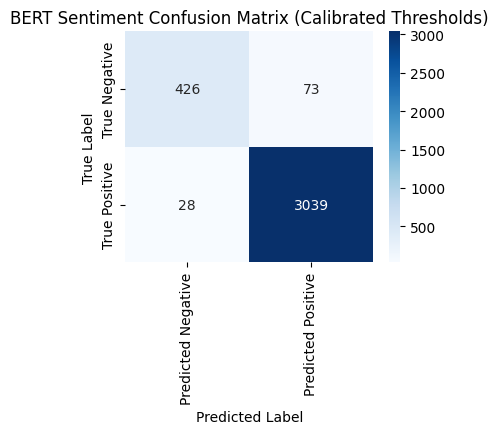


Classification Report:
               precision    recall  f1-score   support

    negative       0.94      0.85      0.89       499
    positive       0.98      0.99      0.98      3067

    accuracy                           0.97      3566
   macro avg       0.96      0.92      0.94      3566
weighted avg       0.97      0.97      0.97      3566



In [83]:
import numpy as np
import torch
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt # Import matplotlib for plotting
import seaborn as sns # Import seaborn for heatmap

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# batched inference to avoid OOM
def batched_predict_logits(texts, batch_size=32):
    all_logits = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + 32]
        enc = tokenizer(
            batch,
            truncation=True,
            padding="max_length",
            max_length=128,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits[:, 4]  # sentiment head
        all_logits.append(logits.cpu().numpy())
    return np.concatenate(all_logits)

all_logits = batched_predict_logits(X_val_txt)         # shape=(n_val,)
probs_pos  = 1 / (1 + np.exp(-all_logits))             # sigmoid → P(pos)
probs_neg  = 1 - probs_pos                             # P(neg)

# Calculate best_thr_pr for the positive class
y_true_pos = S_val # True labels for the positive class (0 or 1)
prec_p, rec_p, thr_p = precision_recall_curve(y_true_pos, probs_pos)
f1_scores_p = 2 * prec_p * rec_p / (prec_p + rec_p + 1e-8)
best_idx_p = np.nanargmax(f1_scores_p)
best_thr_pr = thr_p[best_idx_p]
print(f"Optimal positive-class probability threshold: {best_thr_pr:.4f}")

# tuned thresholds you found:
# best_thr_pr # This is now calculated above
neg_thr_lo = 1 - best_thr_neg # Assuming best_thr_neg was calculated previously in cell CjMb4Z3ufV-A

# final 0/1 predictions
y_pred = np.where(probs_pos >= best_thr_pr, 1,
         np.where(probs_pos <= neg_thr_lo, 0, 1)) # Corrected variable name

# true labels
y_true = S_val  # or y_test if you're on the test set

# report
cm = confusion_matrix(y_true, y_pred) # Calculate confusion matrix

print("Confusion Matrix:\n", cm) # Print confusion matrix

# Plot Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["True Negative", "True Positive"])
plt.title("BERT Sentiment Confusion Matrix (Calibrated Thresholds)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=["negative","positive"]))

In [84]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, classification_report

# make sure your model & tokenizer are loaded, on the right device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

def predict_aspect_sentiment_bert_dual(
    texts,
    aspect_thr: float = 0.5,
    pos_thr: float = best_thr_pr,
    neg_thr: float = best_thr_neg
):
    all_logits = []
    # batch in chunks of 32
    for i in range(0, len(texts), 32):
        batch = texts[i : i + 32]
        enc = tokenizer(
          batch,
          truncation=True,
          padding="max_length",
          max_length=128,
          return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            logits = model(**enc).logits.cpu().numpy()  # shape (batch_size, 5)
        all_logits.append(logits)

    all_logits = np.vstack(all_logits)  # now (n_texts,5)
    probs = 1 / (1 + np.exp(-all_logits))  # sigmoid

    # aspect predictions at 0.5
    aspect_preds = (probs[:, :4] > aspect_thr).astype(int)

    # dual‐threshold for sentiment
    p_pos = probs[:, 4]
    sent_preds = np.where(
      p_pos >= pos_thr, 1,
      np.where(p_pos <= neg_thr, 0, (p_pos > 0.5).astype(int))
    )

    return aspect_preds, sent_preds

# --- pick 5 true negatives + 5 true positives from your TEST set ---
y_true = np.array([1 if lbl=="positive" else 0 for lbl in y_test])
texts  = np.array(X_test)

neg_texts = texts[y_true == 0][:5].tolist()
pos_texts = texts[y_true == 1][:5].tolist()
smoke_texts = neg_texts + pos_texts

assert len(smoke_texts)==10, "Oops, your smoke_texts is empty or too small"

print("=== True Labels (5 neg → 5 pos) ===")
for txt, lbl in zip(smoke_texts, [0]*5 + [1]*5):
    print(f" → ({'neg' if lbl==0 else 'pos'}) {txt}")

# run the dual‐threshold inference
asp_smoke, sent_smoke = predict_aspect_sentiment_bert_dual(
    smoke_texts,
    aspect_thr=0.5,
    pos_thr=best_thr_pr,
    neg_thr=best_thr_neg
)

print("\n=== Model Predictions on Smoke Samples ===")
for txt, a_pred, s_pred in zip(smoke_texts, asp_smoke, sent_smoke):
    asp_dict = dict(zip(['Food','Service','Ambiance','Value'], a_pred))
    print(f" • Aspects: {asp_dict}    Sentiment: {'pos' if s_pred else 'neg'}   {txt}")

print("\nConfusion Matrix:\n", confusion_matrix([0]*5 + [1]*5, sent_smoke))
print("\nClassification Report:\n",
      classification_report([0]*5 + [1]*5, sent_smoke,
                            target_names=["negative","positive"]))

=== True Labels (5 neg → 5 pos) ===
 → (neg) waited line minutes girl working crepe maybe minutes text messages coffee breaks people literally got line didn t just wisdom teeth need soft food horrible service
 → (neg) donuts probable awesome able try times donuts sold just aware relatively good chance donut shop donuts sure good fool shame fool twice shame fool time just moron coming know just guy wants donut shop donuts
 → (neg) strawberry wasn t good tasted old like carton comes m ice cream lover eat ice cream just couldn t finish
 → (neg) terrible customer service treats good places city sweets money happy work downtown visited shop numerous times pleasant experience staff teenagers working busy phones care helping visited minutes close immediately met annoyance clear girl counter didn t want help wanted leave left handed won t going
 → (neg) disappointed friend excited famous sprinkles cupcakes vacation vegas week ordered different flavors couldn t wait dig waste money quality said